# Loan default rish assessment
#### Problem Statement:- Given borrowers who have already been approved for a loan, estimate the probability that each borrower will default, using their credit and financial history, in order to support risk management and loss prevention decisions.

In [1]:
# importing the necessary modules for Exploratory Data Analysis and model building and model testing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [2]:
# loading the data
df = pd.read_csv('Loan_default.csv')

In [3]:
#showing the top 5 head data
df.head(n=5)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
#information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [5]:
# checking whether there are null/nan values present in the data
df.isna().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [6]:
# checking whether there are null/nan values present in the data
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [7]:
df['monthly_income'] = round(df['Income'] / 12, 2)
df['EMI'] = round(((df['LoanAmount']*df['InterestRate']) + df['LoanAmount'])/df['LoanTerm'], 2)

In [8]:
# Define feature columns (all columns except LoanID and Default)
features = df.drop(columns=['LoanID', 'Default']).columns

# Define target column for prediction
target = ['Default']

In [9]:
loan_ids = df.drop(columns=['LoanID'])
df_copy = df.drop(columns=['LoanID'])

In [10]:
def categorize_columns(df: pd.DataFrame) -> tuple[list[str], list[str]]:
    """
    Categorize DataFrame columns into numerical and categorical types.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze
        
    Returns:
        tuple[list[str], list[str]]: A tuple containing:
            - List of numerical column names (int64, float64)
            - List of categorical column names (object, category)
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    return numerical_cols, categorical_cols

# Usage example:
numerical_cols, categorical_cols = categorize_columns(df_copy)

In [11]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,monthly_income,EMI
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0,7166.17,22806.31
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0,4202.67,12049.94
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1,7017.33,119337.42
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0,2642.75,15063.66
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0,1703.08,1429.87


In [12]:
#checking the number of defaults and non-defaults for DTIRatio above or equal to 0.6
df.query('DTIRatio >= 0.6')['Default'].value_counts()

Default
0    85606
1    11930
Name: count, dtype: int64

In [13]:
# Get the count of default values for unemployed individuals
df.query('EmploymentType == "Unemployed"')['Default'].value_counts()

Default
0    55174
1     8650
Name: count, dtype: int64

In [14]:
def categorize_default_status(df: pd.DataFrame, source_col: str = 'Default', target_col: str = 'Default_cat') -> pd.DataFrame:
    """
    Categorizes binary default status (0/1) into descriptive categories.
    
    Args:
        df (pd.DataFrame): DataFrame containing the default status column
        source_col (str, optional): Name of the column containing binary default values. Defaults to 'Default'.
        target_col (str, optional): Name for the new categorical column. Defaults to 'Default_cat'.
    
    Returns:
        pd.DataFrame: DataFrame with the new categorical column added
    """
    category_mapping = {0: 'Non-Default', 1: 'Default'}
    df[target_col] = df[source_col].map(category_mapping)
    return df

# Usage:
df_copy = categorize_default_status(df_copy)

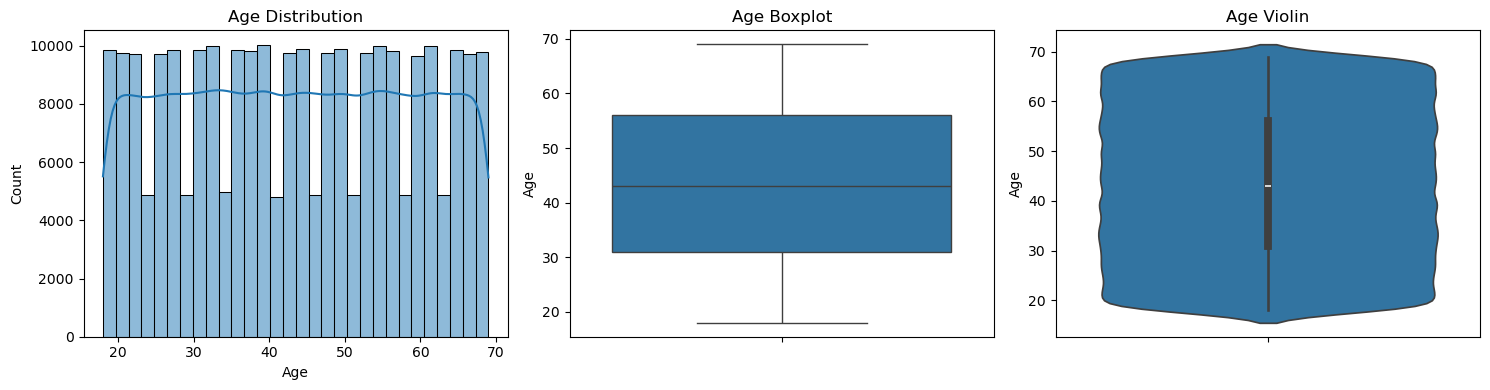

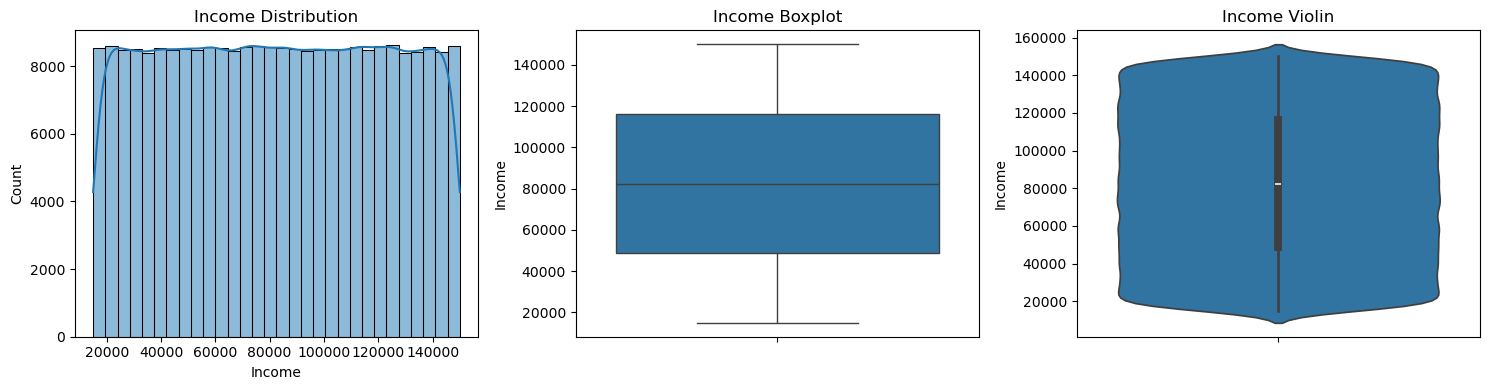

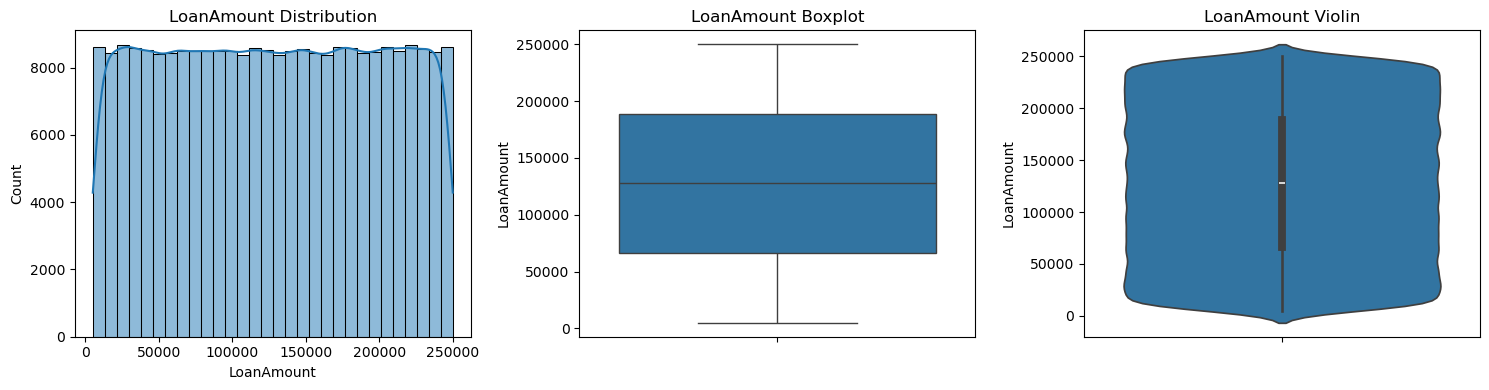

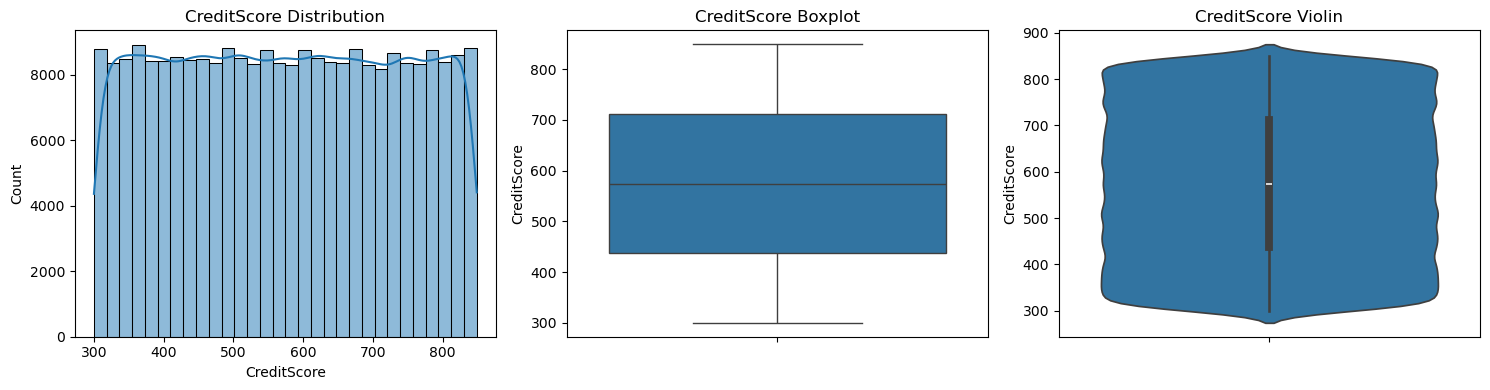

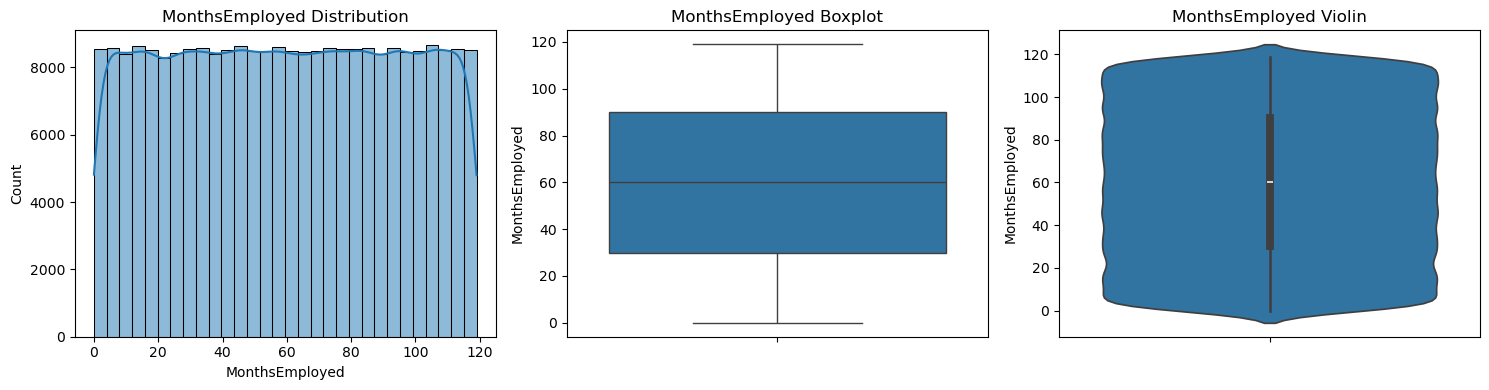

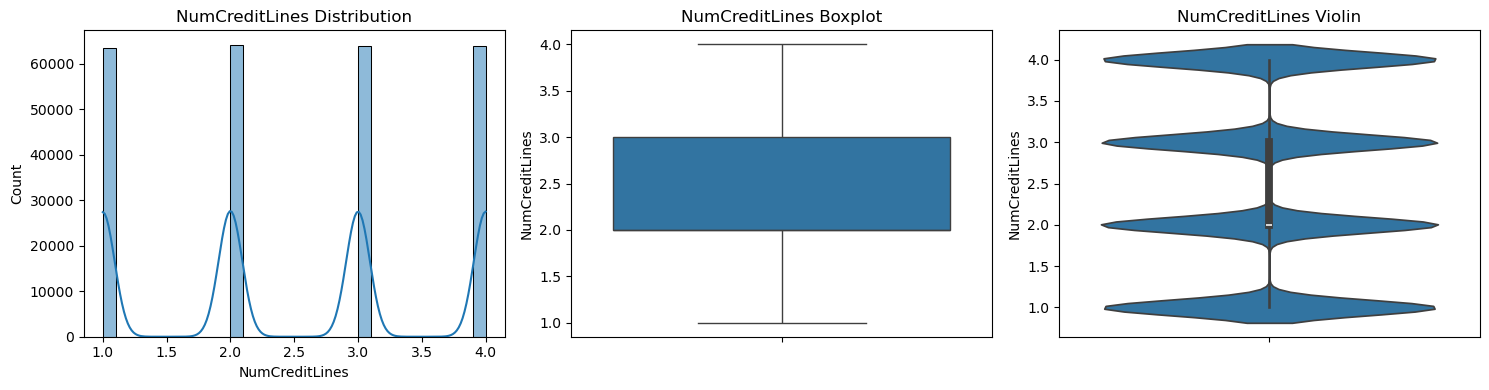

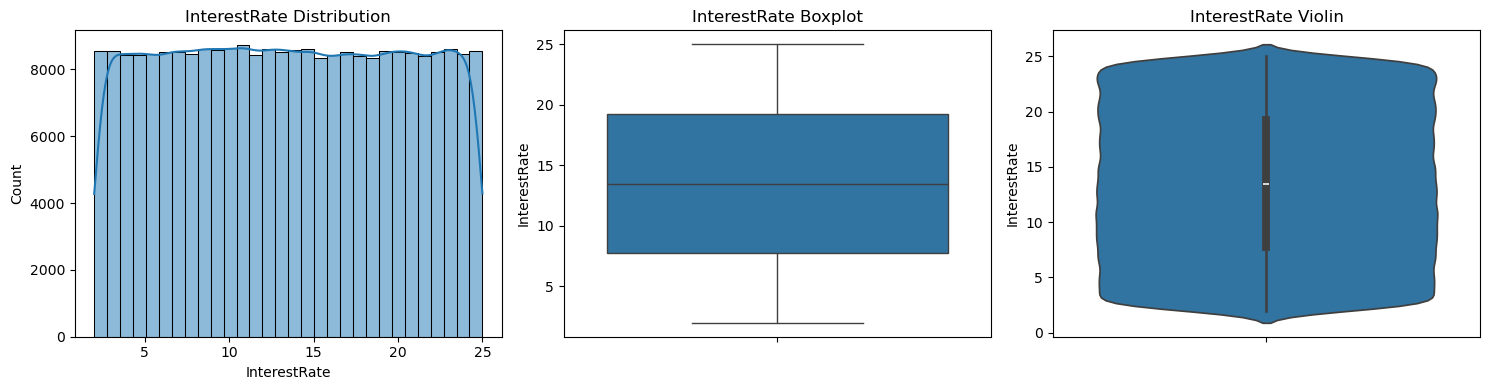

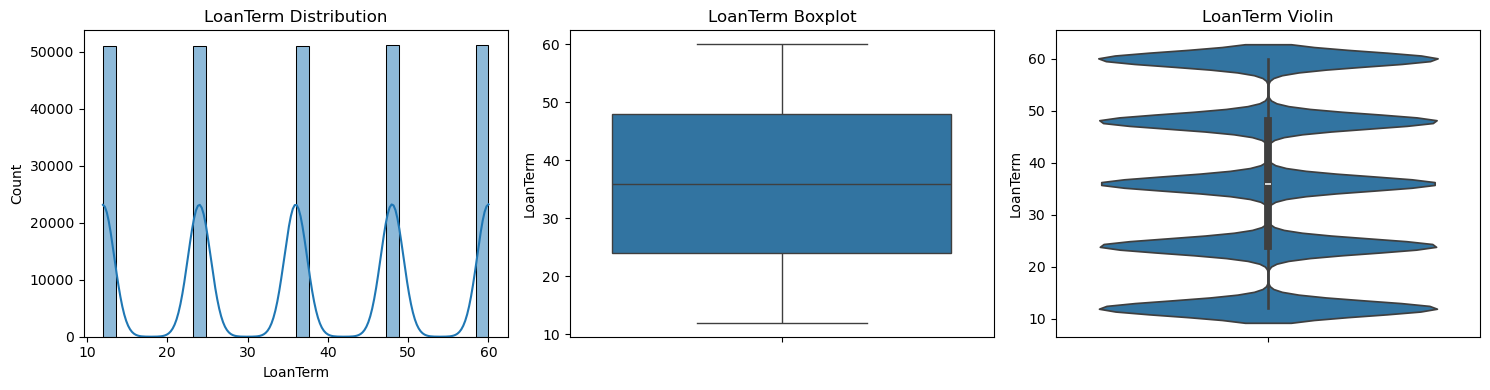

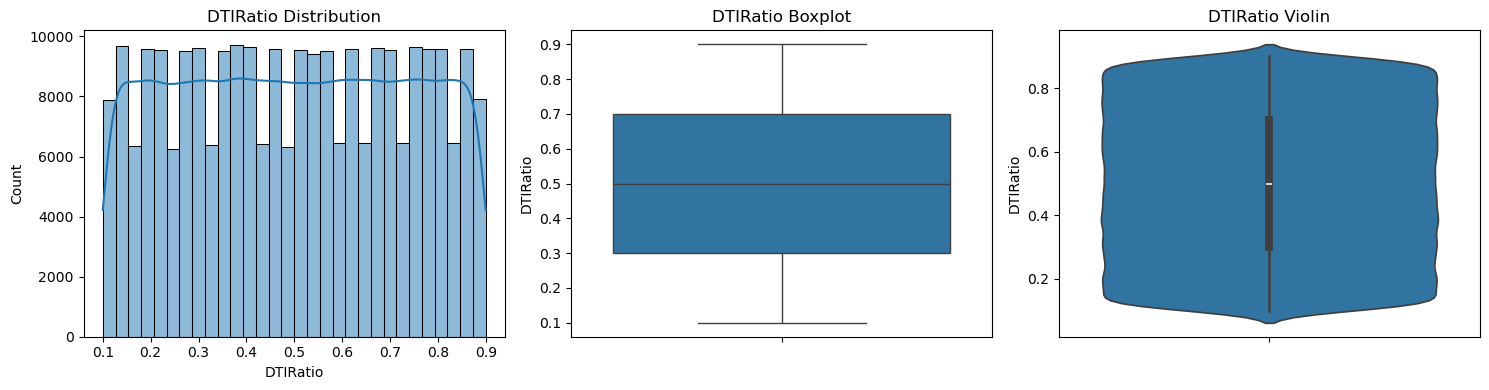

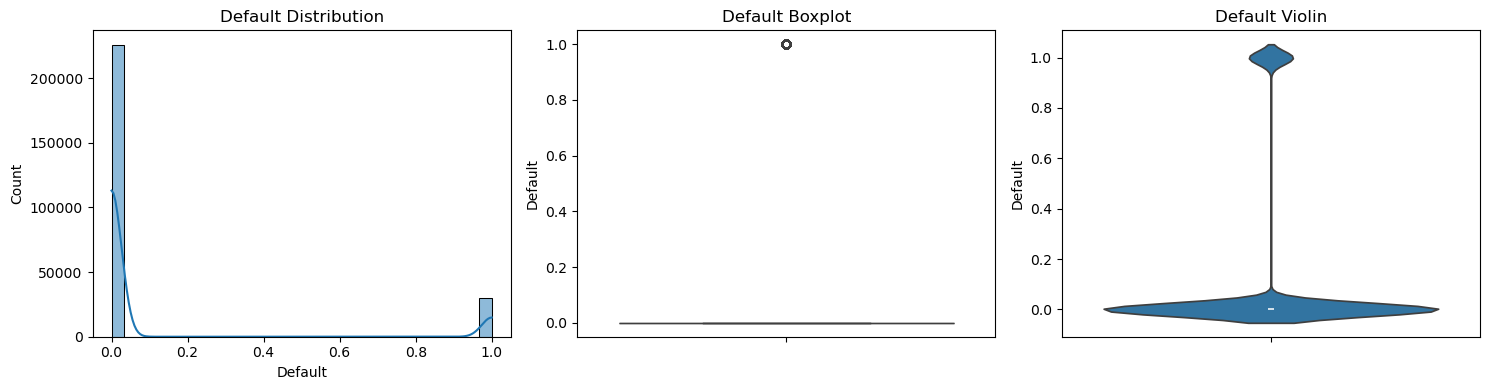

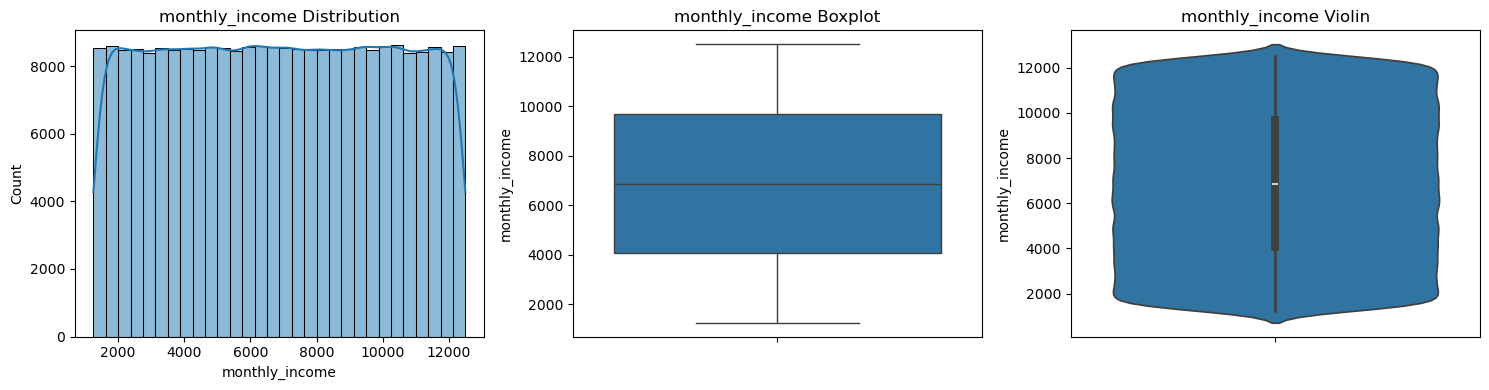

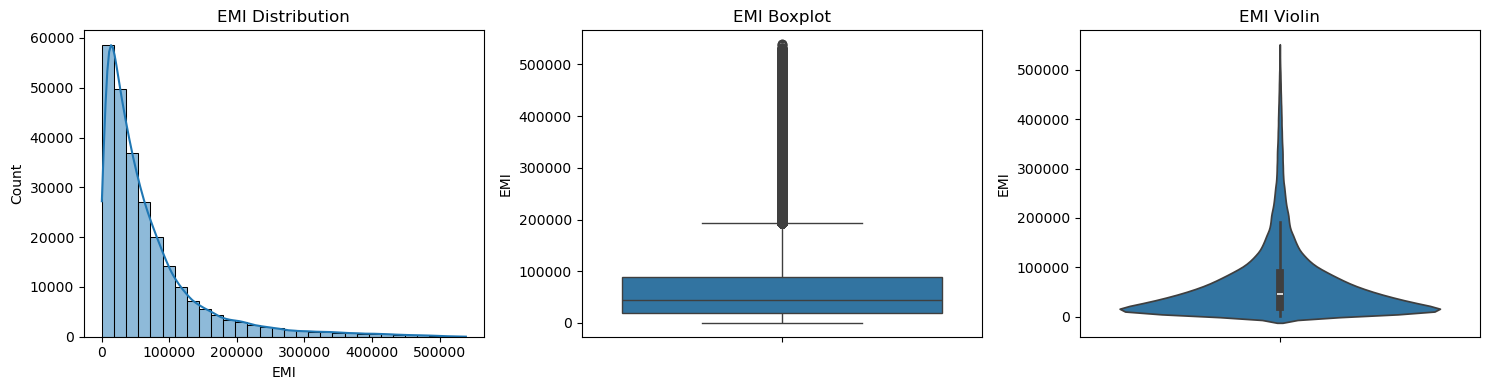

In [15]:
# plotting the variables and doing univariate analysis of each variable
for col in numerical_cols:
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    sns.histplot(df_copy[col], ax=ax[0], bins=30, kde=True)
    ax[0].set_title("{} Distribution".format(col))

    sns.boxplot(df_copy[col], ax=ax[1])
    ax[1].set_title("{} Boxplot".format(col))

    sns.violinplot(df_copy[col], ax=ax[2])
    ax[2].set_title("{} Violin".format(col))

    plt.tight_layout()
    plt.show()

In [16]:
#checking the skewness of features
df_copy[numerical_cols].skew()

Age               0.000698
Income           -0.000381
LoanAmount       -0.001827
CreditScore       0.004688
MonthsEmployed   -0.002142
NumCreditLines   -0.000278
InterestRate      0.004608
LoanTerm         -0.002178
DTIRatio         -0.001499
Default           2.396377
monthly_income   -0.000381
EMI               2.334776
dtype: float64

In [17]:
#Grouping the data for defaults as per the employment type
employment_df = df_copy.groupby('EmploymentType')['Default_cat'].value_counts().reset_index()

In [18]:
employment_df

,EmploymentType,Default_cat,count
0,Full-time,Non-Default,57632
1,Full-time,Default,6024
2,Part-time,Non-Default,56484
3,Part-time,Default,7677
4,Self-employed,Non-Default,56404
5,Self-employed,Default,7302
6,Unemployed,Non-Default,55174
7,Unemployed,Default,8650


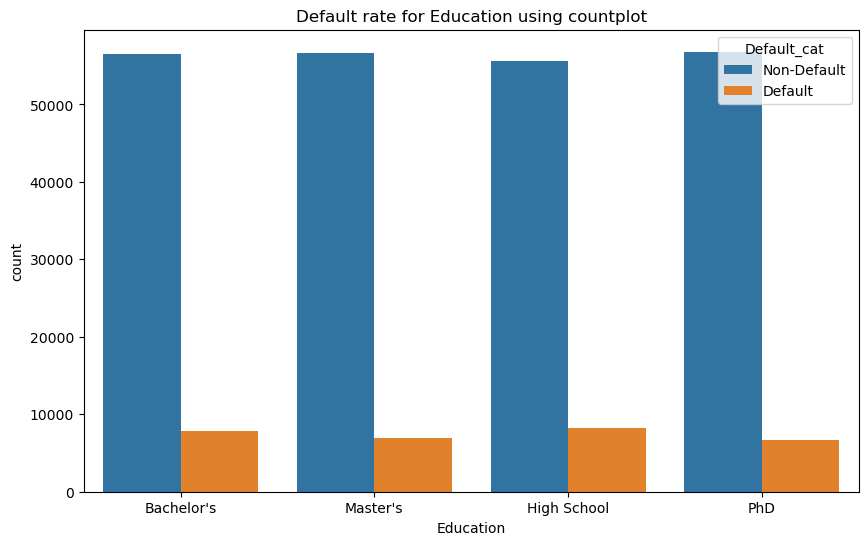

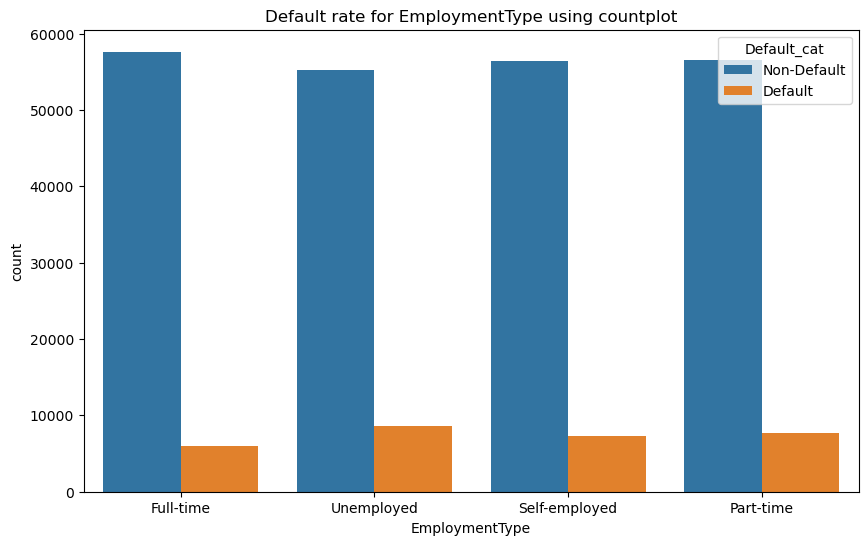

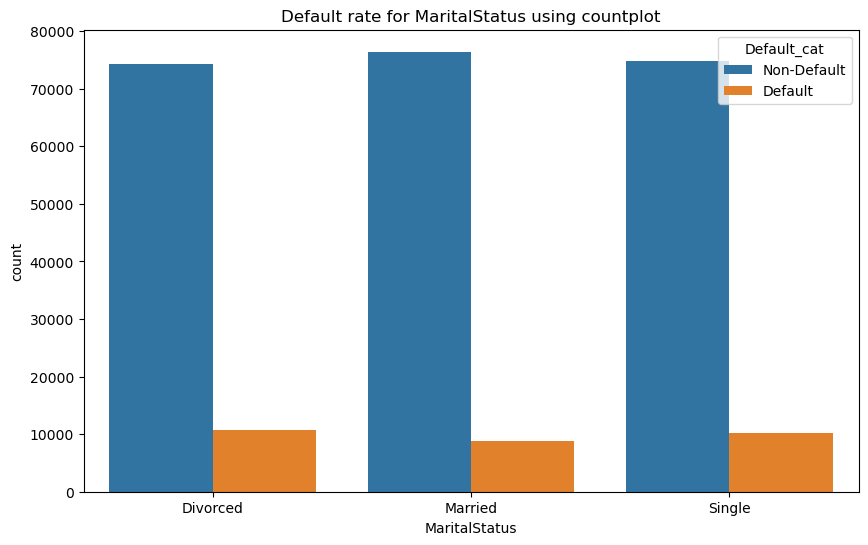

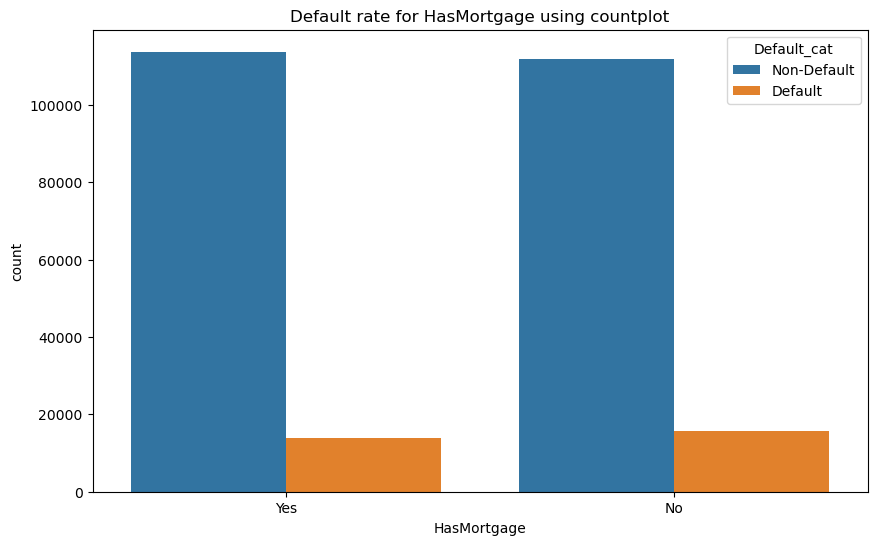

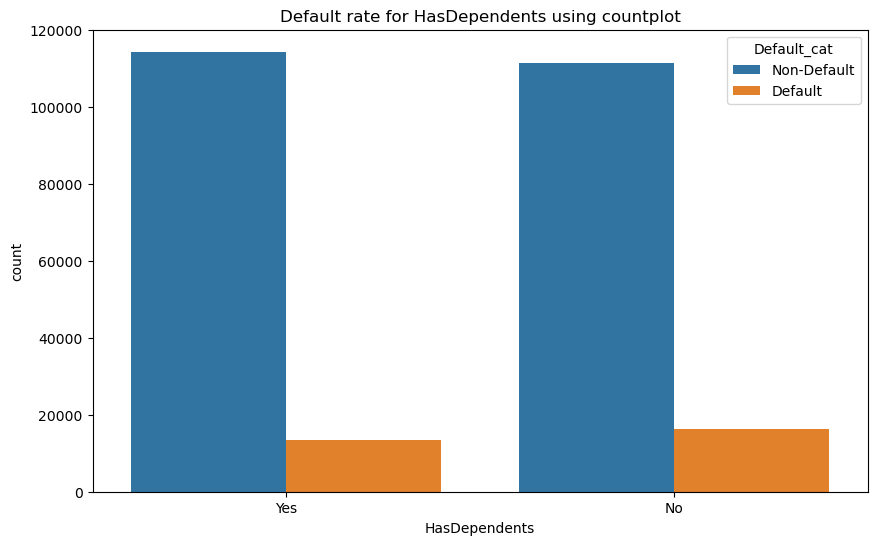

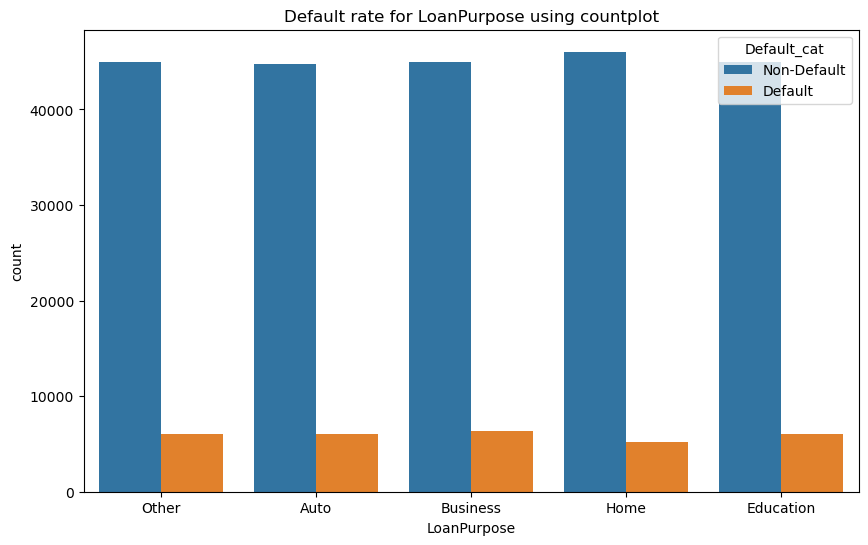

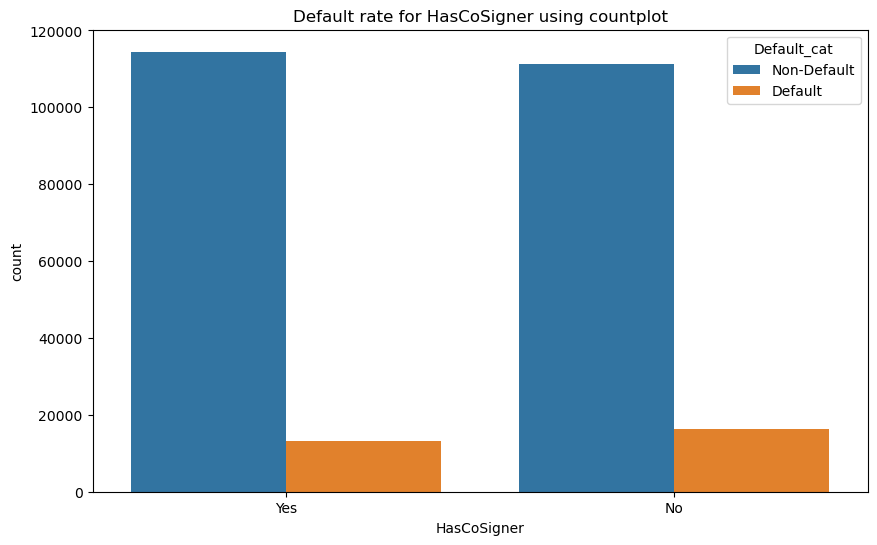

In [19]:
#plotting categorical variables with respect to the default category
for col in categorical_cols:
    plt.figure(figsize=(10,6))
    sns.countplot(df_copy, x=col, hue='Default_cat')
    plt.title('Default rate for {} using countplot'.format(col))
    plt.show()

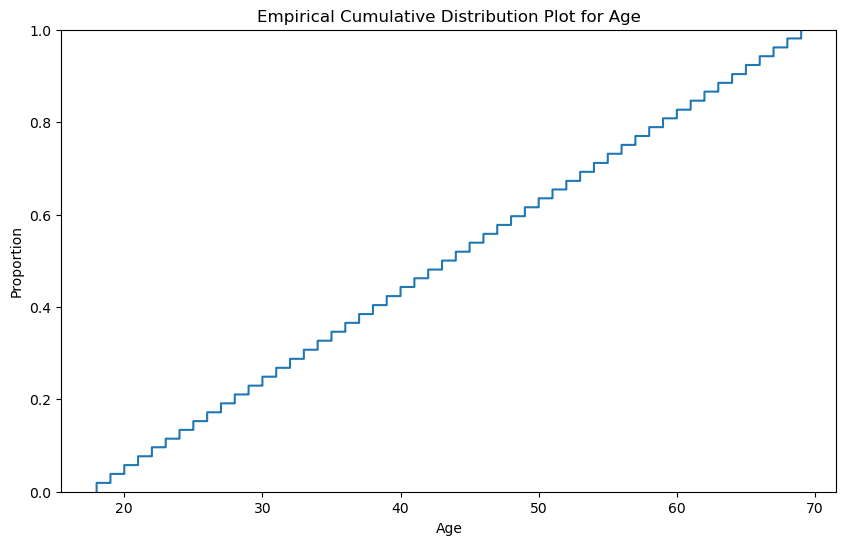

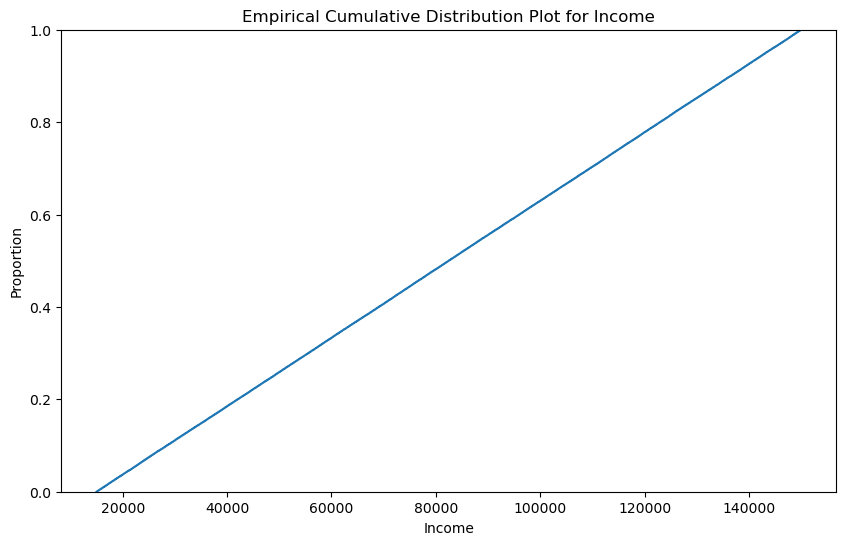

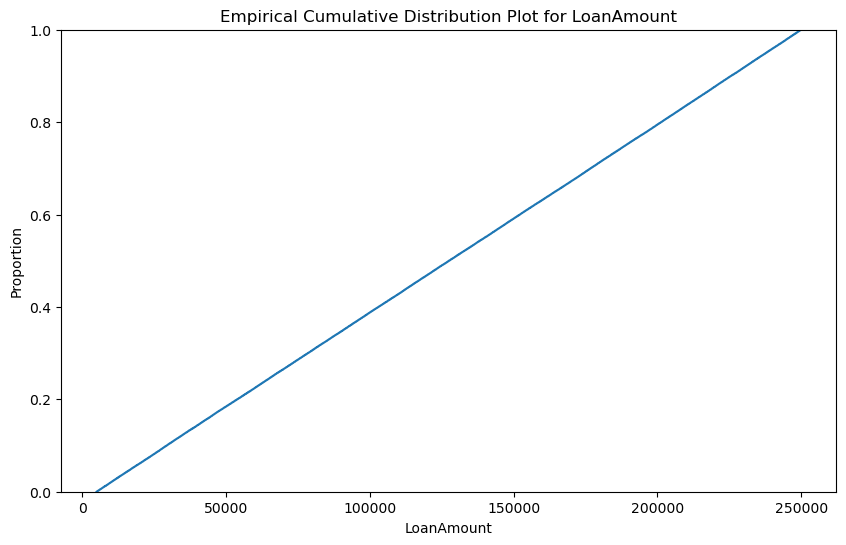

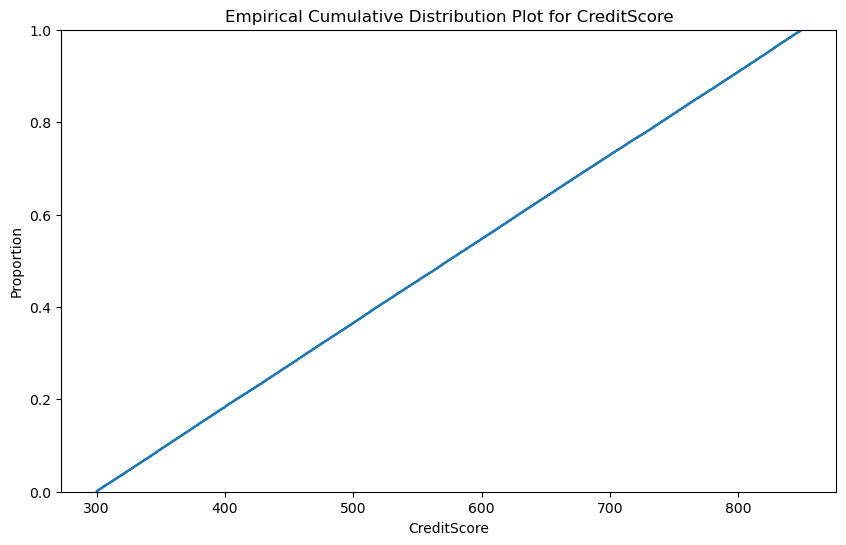

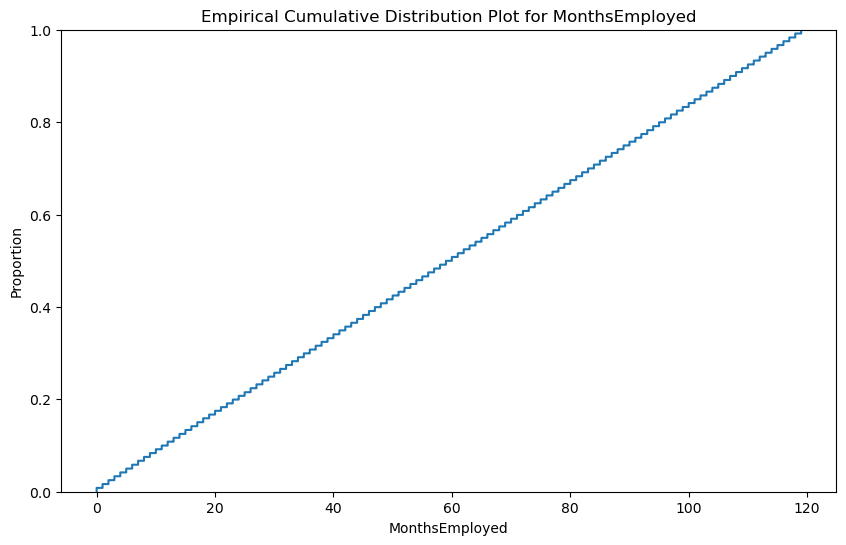

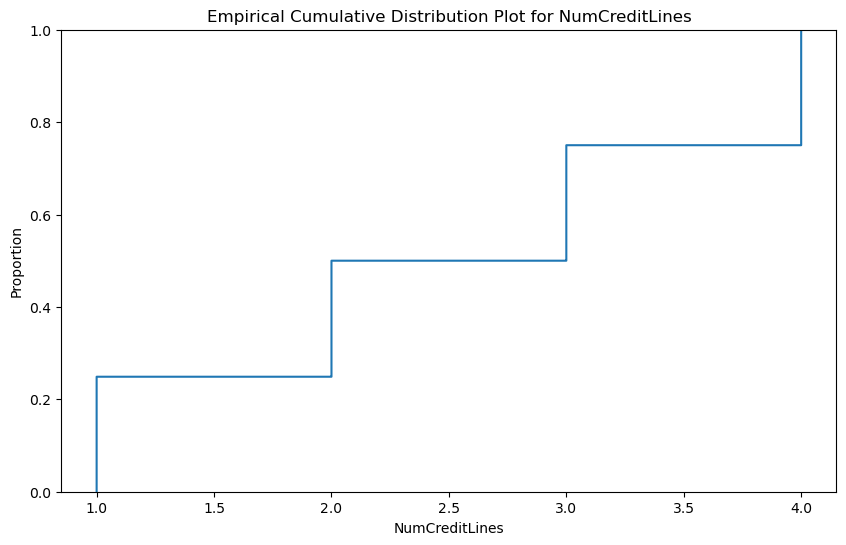

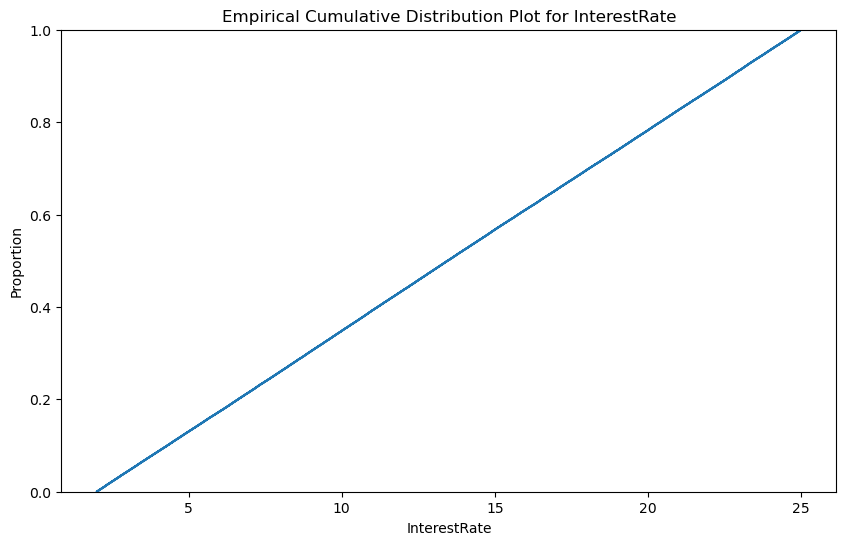

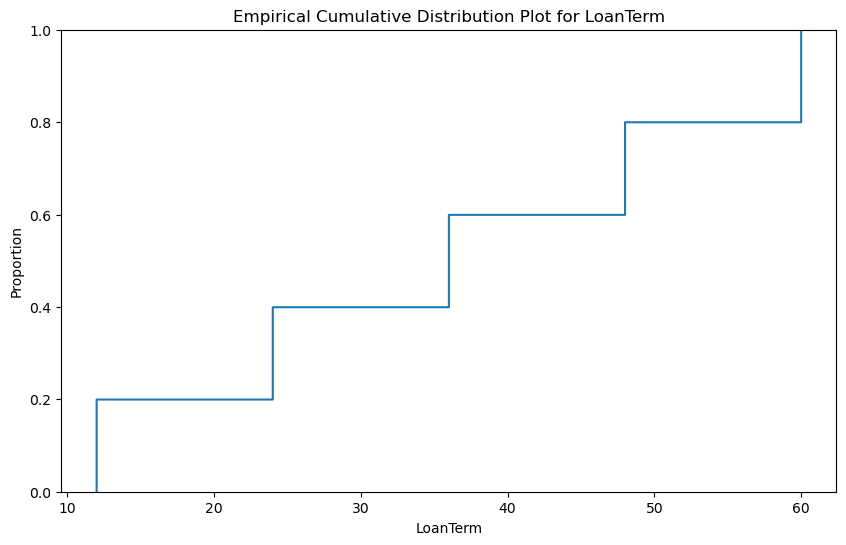

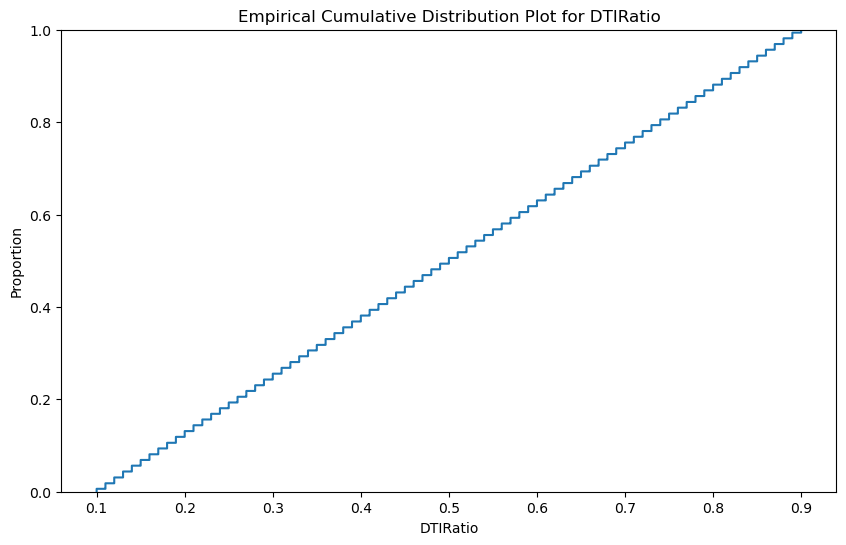

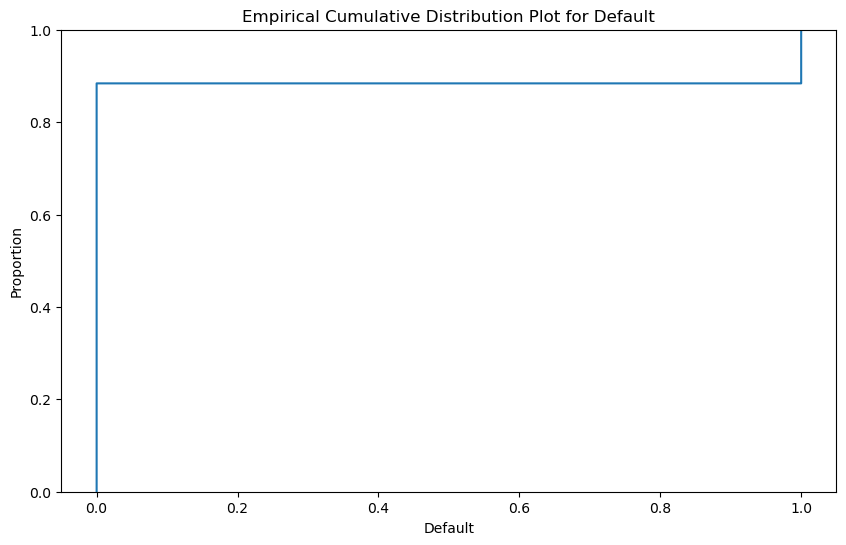

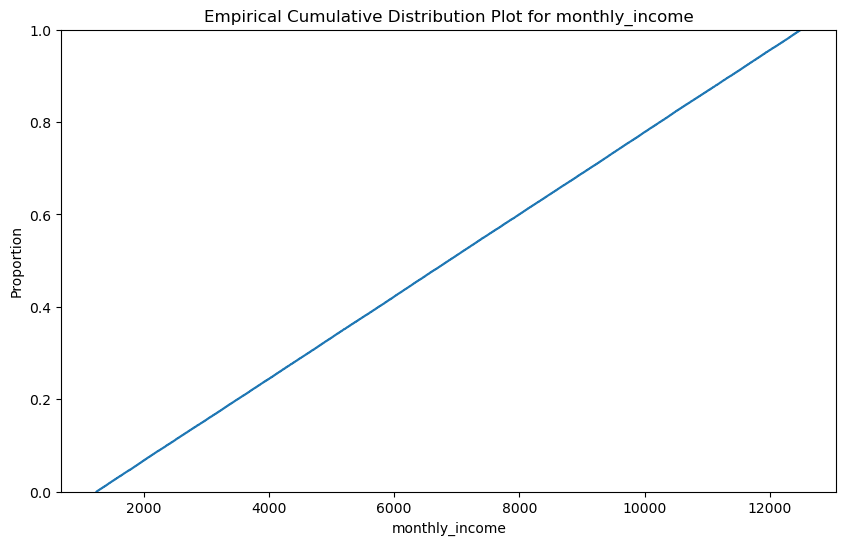

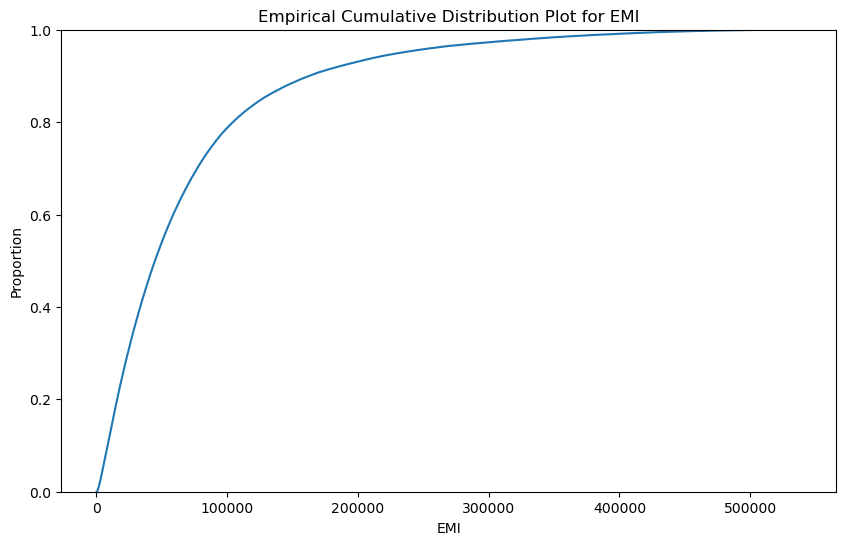

In [20]:
#ECDF analysis of numerical features
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(df_copy, x=col)
    plt.title('Empirical Cumulative Distribution Plot for {}'.format(col))
    plt.show()

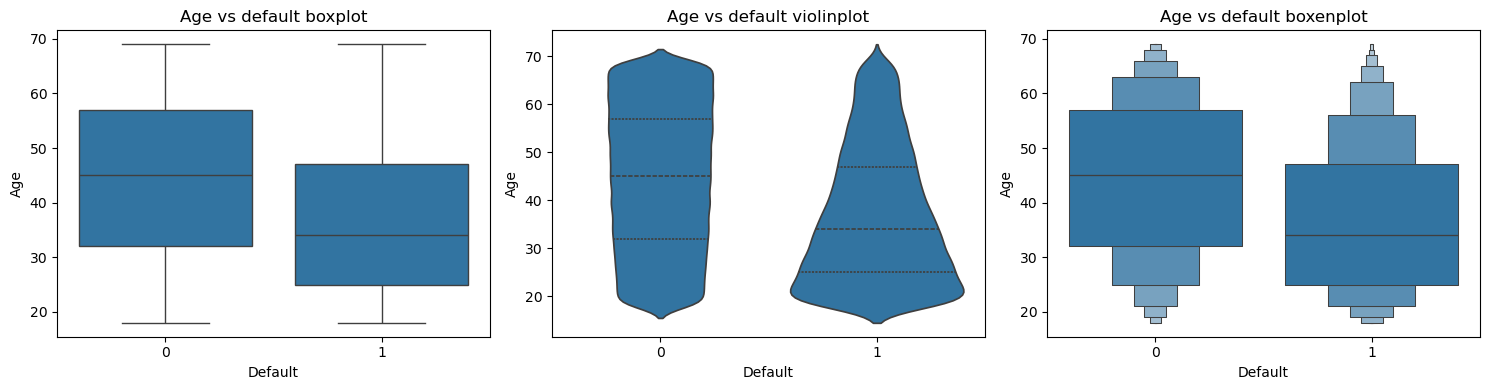

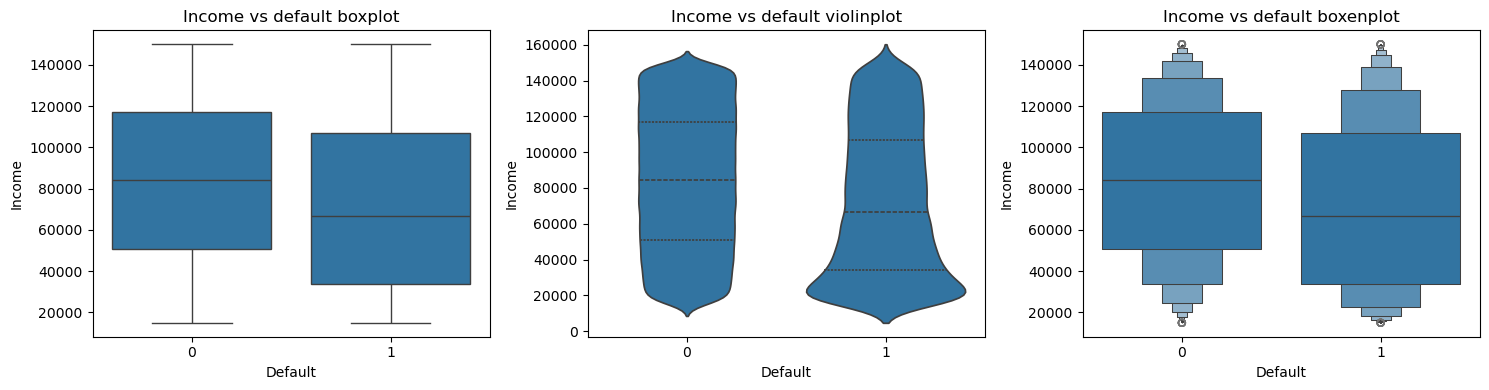

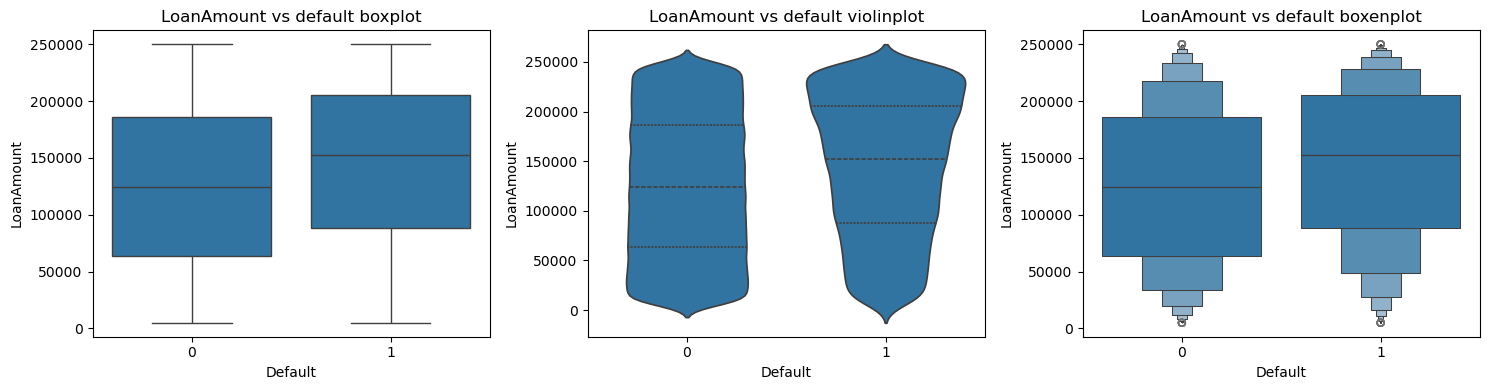

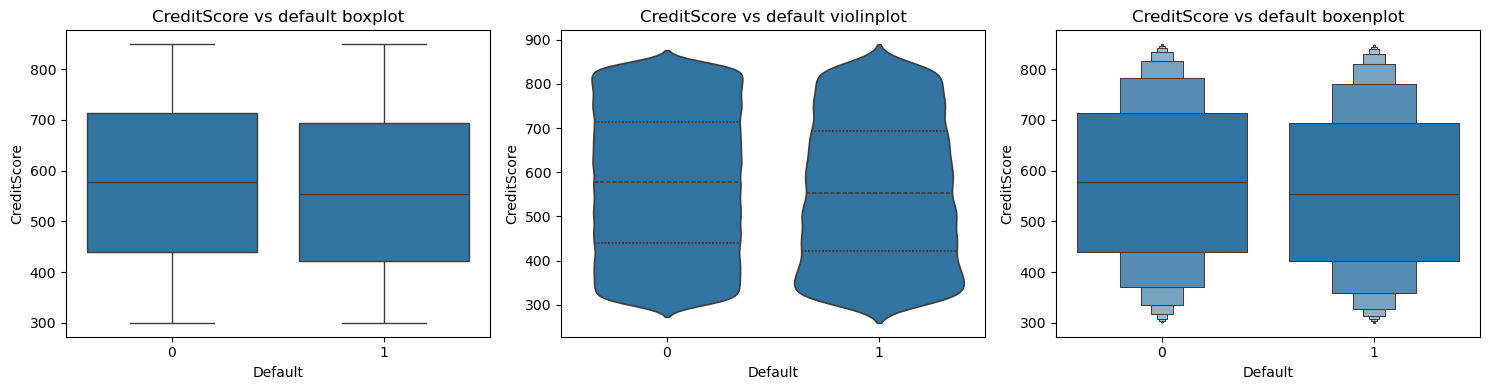

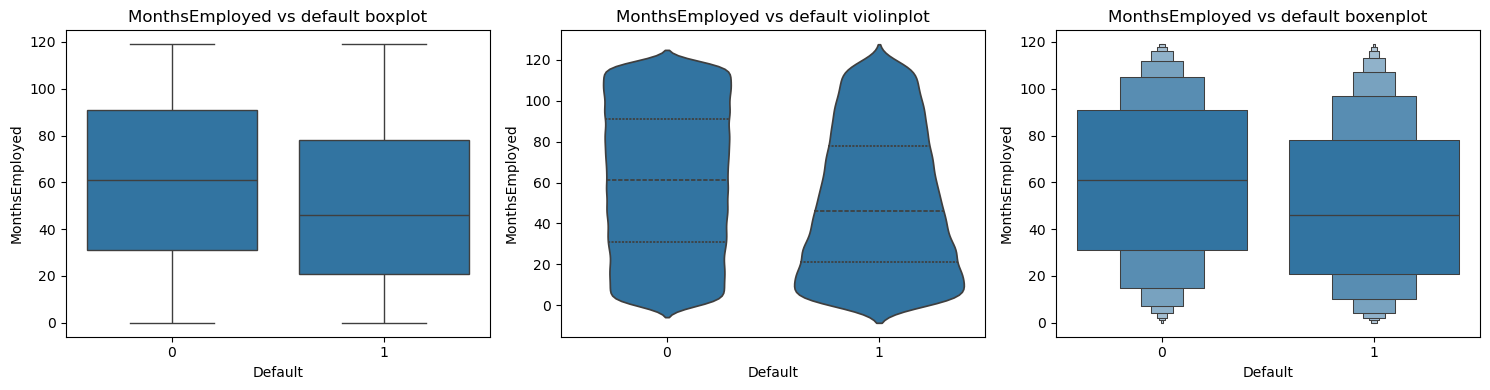

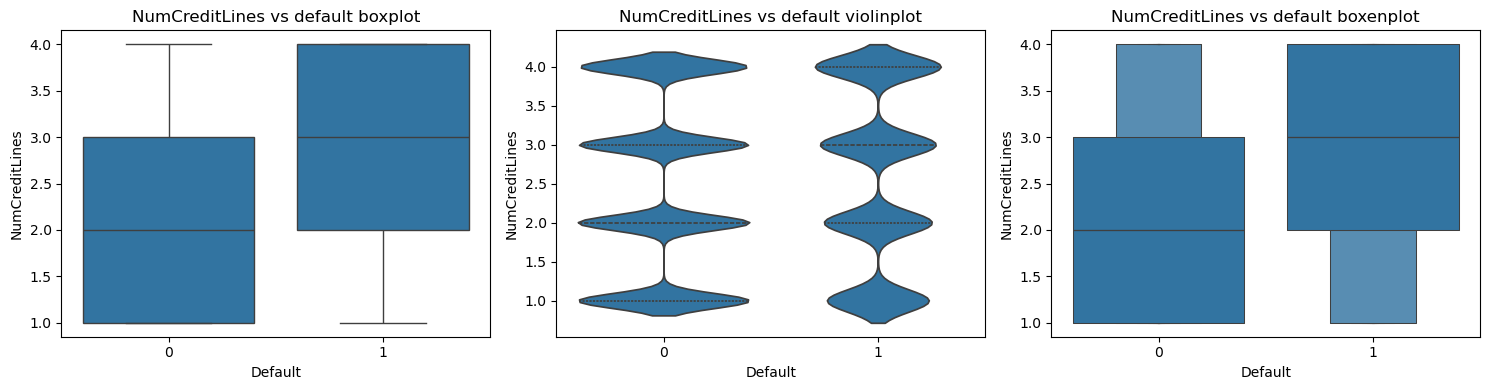

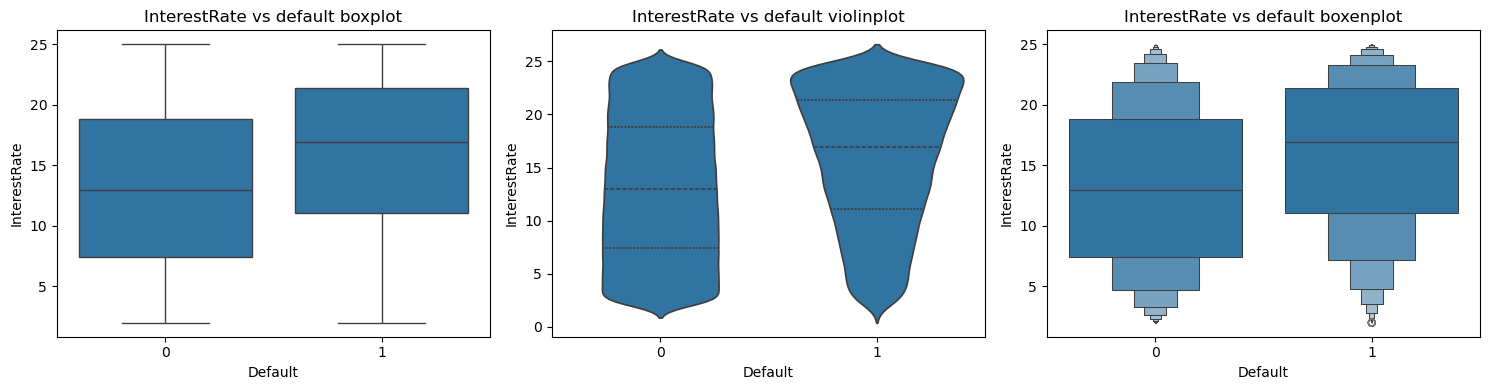

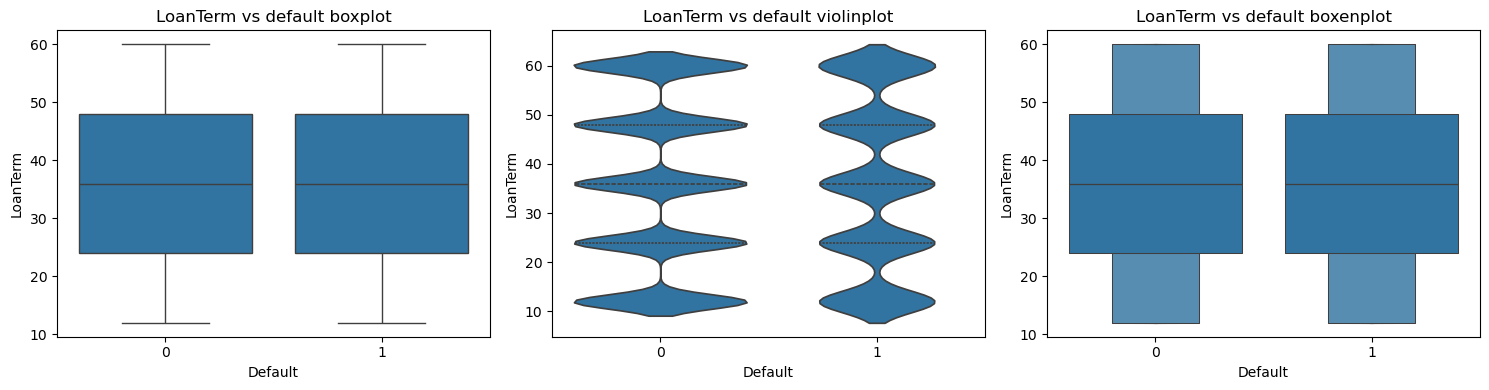

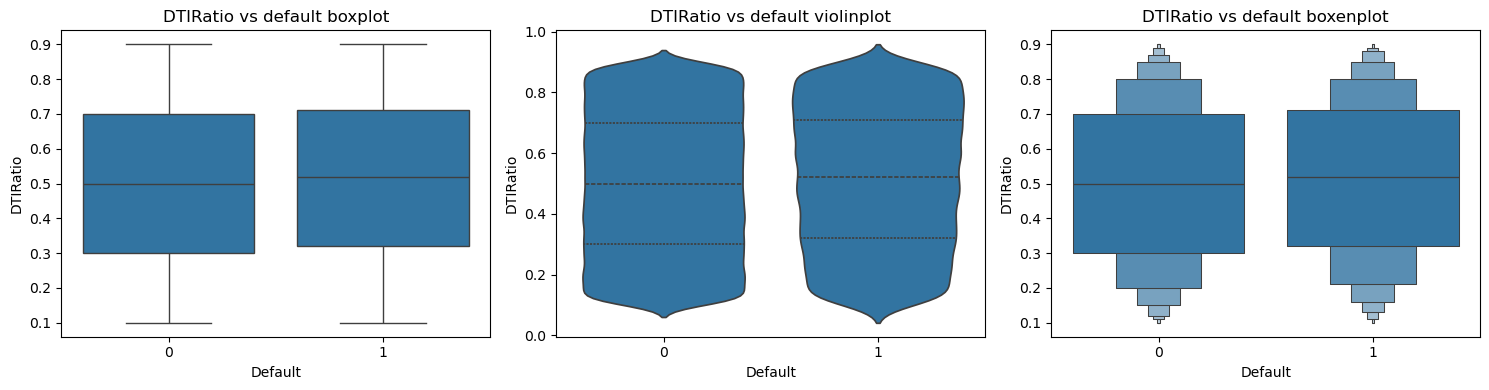

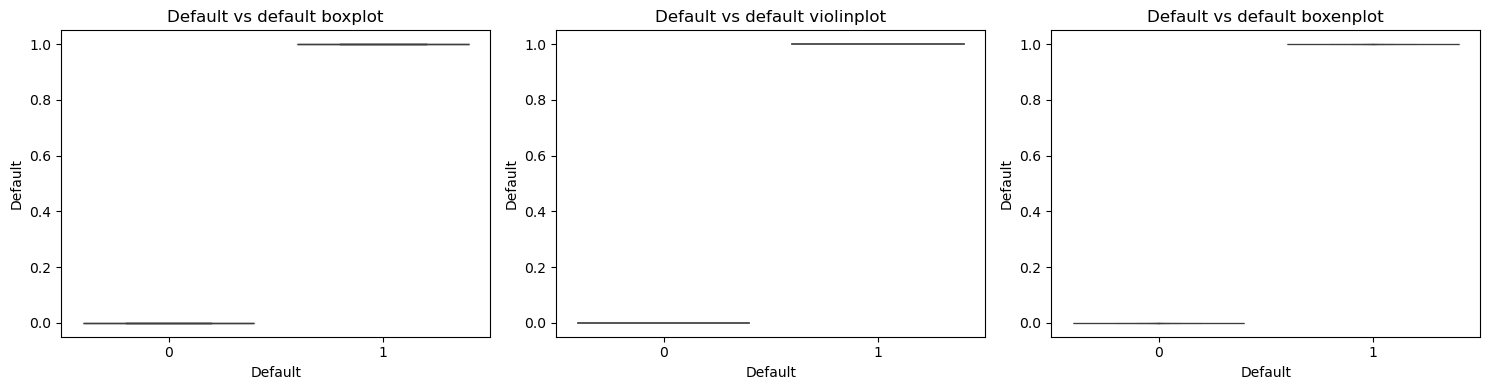

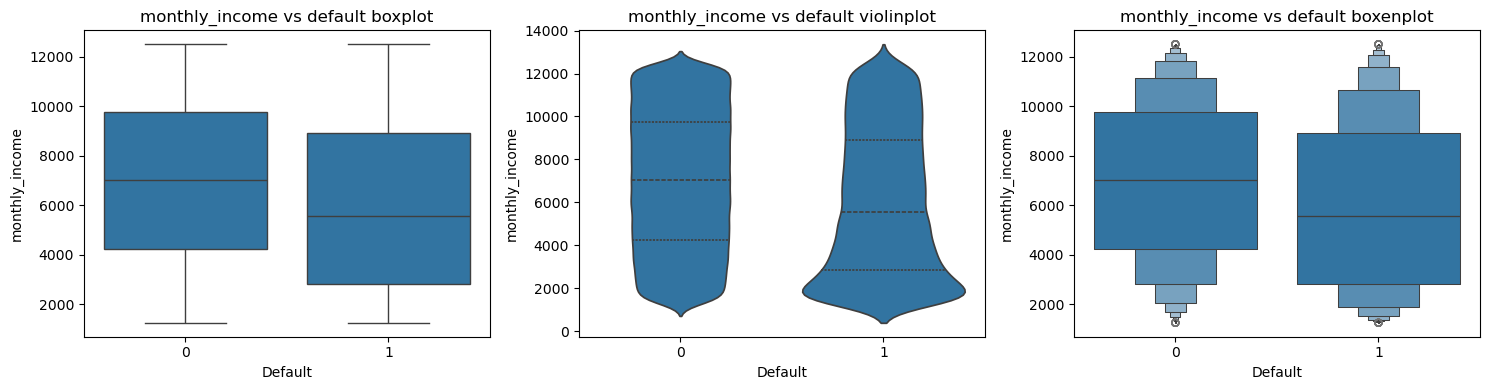

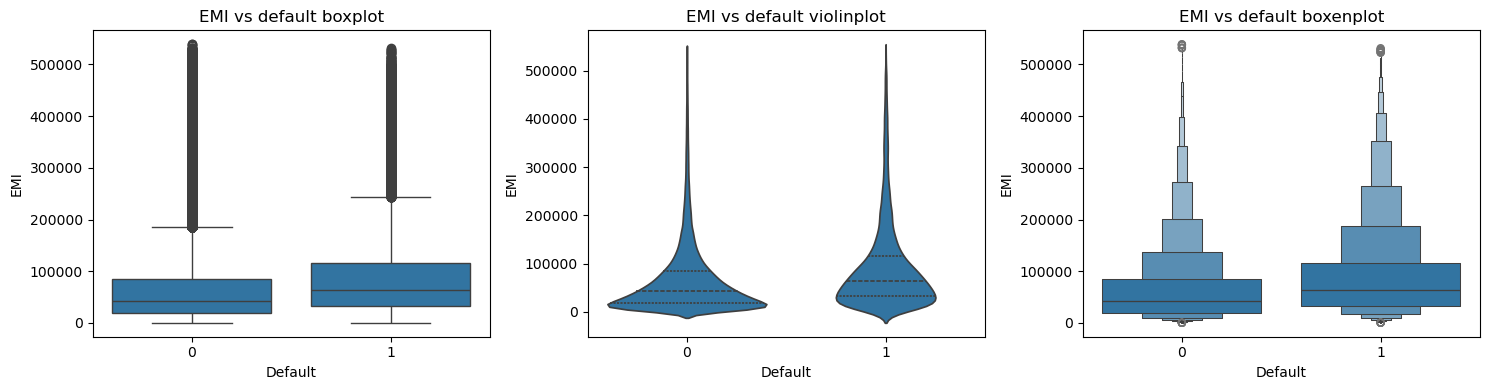

In [21]:
#plotting the features vs target variable where default is target
for col in numerical_cols:
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    sns.boxplot(df_copy, x='Default',  y=col, ax=ax[0])
    ax[0].set_title("{} vs default boxplot".format(col))

    sns.violinplot(df_copy, x='Default', y=col, inner='quartile', ax=ax[1])
    ax[1].set_title("{} vs default violinplot".format(col))

    sns.boxenplot(data=df_copy, x='Default', y=col, ax=ax[2])
    ax[2].set_title("{} vs default boxenplot".format(col))

    plt.tight_layout()
    plt.show()

In [22]:
# describe method helps in calculating measures of Central Tendency(mean, median, std and var)
df_copy.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,monthly_income,EMI
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128,6874.942054,70195.303460
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379,3246.917814,77530.535787
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000,1250.000000,305.230000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000,4068.790000,19937.350000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000,6872.170000,44892.660000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000,9684.920000,89007.535000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000,12499.920000,538920.810000


In [23]:
# separating the features from target
X = df_copy.drop(columns=['Default','Default_cat'])
y = df_copy[target]

In [24]:
#Creates preprocessing pipelines for numerical and categorical features.
from sklearn.impute import SimpleImputer
numerical_transformer = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [25]:
# removing target from features list to avoid leakage
numerical_cols.remove('Default')

In [26]:
# checking the defaulters and non-defaulters
df_copy['Default'].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [27]:
# Define transformers for different column types
transformers = [
    ('numerical_transformation', numerical_transformer, numerical_cols),
    ('categorical_transformation', categorical_transformer, categorical_cols)
]

# Create a preprocessor that applies appropriate transformations to each column type
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough'  # Pass through any columns not specified in transformers
)

In [28]:
# basic logistic model with balanced and unbalanced approach
lg_model_bal = LogisticRegression(max_iter=2000, class_weight='balanced')
lg_unbal = LogisticRegression(max_iter=2000)
lg_pipeline_bal = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('lg_model_balanced', lg_model_bal)
])
lg_pipeline_unbal = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('lg_model_unbalanced', lg_unbal)
])

In [29]:
# model cross-validation check
from sklearn.model_selection import cross_val_score
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_score_bal = cross_val_score(lg_pipeline_bal, X, y.values.ravel(), cv=skf, scoring='roc_auc')
cv_score_unbal = cross_val_score(lg_pipeline_unbal, X, y.values.ravel(), cv=skf, scoring='roc_auc')

In [30]:
# calculating mean and median of cross-validation score
cv_score_bal.mean(), np.median(cv_score_bal), cv_score_unbal.mean(), np.median(cv_score_unbal)

(0.7477412442179798,
 0.7467282994919573,
 0.7476564346956822,
 0.7464485505713432)

In [31]:
from sklearn.model_selection import cross_val_predict
from typing import Any, Dict, Union
import numpy as np
import pandas as pd

def generate_out_of_fold_predictions(
    model: Any,
    features: Union[pd.DataFrame, np.ndarray],
    target: Union[pd.Series, np.ndarray],
    cv_strategy: Any,
    prediction_method: str = 'predict'
) -> np.ndarray:
    """
    Generate out-of-fold predictions using cross-validation.
    
    Args:
        model: The machine learning model/pipeline to use for predictions
        features: Feature matrix for the model
        target: Target variable
        cv_strategy: Cross-validation strategy (e.g., KFold, StratifiedKFold)
        prediction_method: Method to use for prediction ('predict', 'predict_proba', etc.)
        
    Returns:
        np.ndarray: Array of out-of-fold predictions
    """
    return cross_val_predict(
        model, 
        features, 
        target.values.ravel() if hasattr(target, 'values') else target,
        cv=cv_strategy,
        method=prediction_method
    )

# Generate out-of-fold predictions for balanced and unbalanced models
y_prob_oof_bal = generate_out_of_fold_predictions(
    model=lg_pipeline_bal,
    features=X,
    target=y,
    cv_strategy=skf
)

y_prob_oof_unbal = generate_out_of_fold_predictions(
    model=lg_pipeline_unbal,
    features=X,
    target=y,
    cv_strategy=skf
)

In [32]:
def print_classification_metrics(y_true: list, y_pred_balanced: list, y_pred_unbalanced: list = None) -> None:
    """
    Print classification metrics for model predictions.
    
    Args:
        y_true (list): Ground truth labels.
        y_pred_balanced (list): Predictions from balanced model.
        y_pred_unbalanced (list, optional): Predictions from unbalanced model.
            If provided, metrics for both models will be compared.
    
    Returns:
        None: Results are printed to console.
    """
    from sklearn.metrics import classification_report, confusion_matrix
    
    print("Classification Report for Balanced Model:")
    print(classification_report(y_true, y_pred_balanced))
    
    if y_pred_unbalanced is not None:
        print("\nClassification Report for Unbalanced Model:")
        print(classification_report(y_true, y_pred_unbalanced))

# Usage example:
print_classification_metrics(y, y_prob_oof_bal, y_prob_oof_unbal)

Classification Report for Balanced Model:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79    225694
           1       0.22      0.69      0.33     29653

    accuracy                           0.68    255347
   macro avg       0.58      0.68      0.56    255347
weighted avg       0.86      0.68      0.73    255347


Classification Report for Unbalanced Model:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94    225694
           1       0.59      0.03      0.07     29653

    accuracy                           0.89    255347
   macro avg       0.74      0.52      0.50    255347
weighted avg       0.85      0.89      0.84    255347



In [33]:
def print_confusion_matrices(y_true: np.ndarray, y_pred_unbalanced: np.ndarray, y_pred_balanced: np.ndarray) -> None:
    """
    Print confusion matrices for both unbalanced and balanced predictions.
    
    Args:
        y_true (np.ndarray): True labels
        y_pred_unbalanced (np.ndarray): Predicted labels from unbalanced model
        y_pred_balanced (np.ndarray): Predicted labels from balanced model
    """
    print("Confusion Matrix (Unbalanced Model):")
    print(confusion_matrix(y_true, y_pred_unbalanced))
    
    print("\nConfusion Matrix (Balanced Model):")
    print(confusion_matrix(y_true, y_pred_balanced))

# Usage:
print_confusion_matrices(y, y_prob_oof_unbal, y_prob_oof_bal)

Confusion Matrix (Unbalanced Model):
[[224995    699]
 [ 28633   1020]]

Confusion Matrix (Balanced Model):
[[152358  73336]
 [  9209  20444]]


In [34]:
def get_cross_val_probabilities(pipeline, X_data, y_data, cv_strategy, class_index=1):
    """
    Performs cross-validation and returns predicted probabilities for a specific class.
    
    Args:
        pipeline (sklearn.pipeline.Pipeline): The pipeline to use for prediction.
        X_data (pd.DataFrame or np.ndarray): Feature data.
        y_data (pd.Series or np.ndarray): Target data.
        cv_strategy (sklearn.model_selection): Cross-validation strategy.
        class_index (int, optional): Index of the class to return probabilities for. Defaults to 1.
    
    Returns:
        np.ndarray: Predicted probabilities for the specified class.
    """
    # Ensure y is 1D array
    y_flat = y_data.values.ravel() if hasattr(y_data, 'values') else y_data
    
    # Get predicted probabilities using cross-validation
    probabilities = cross_val_predict(
        pipeline, X_data, y_flat,
        cv=cv_strategy,
        method='predict_proba'
    )[:, class_index]
    
    return probabilities

# Get predicted probabilities for balanced and unbalanced models
y_pred_bal = get_cross_val_probabilities(lg_pipeline_bal, X, y, skf)
y_pred_unbal = get_cross_val_probabilities(lg_pipeline_unbal, X, y, skf)

In [35]:
def convert_probabilities_to_binary(predictions: np.ndarray, threshold: float = 0.45) -> np.ndarray:
    """
    Convert probability predictions to binary values based on a threshold.
    
    Args:
        predictions: Array of probability predictions
        threshold: Threshold value for binary classification (default: 0.45)
        
    Returns:
        Array of binary predictions (0 or 1)
    """
    return (predictions >= threshold).astype(int)

# Apply the function to both prediction sets
y_pred_bal = convert_probabilities_to_binary(y_pred_bal)
y_pred_unbal = convert_probabilities_to_binary(y_pred_unbal)

In [36]:
from sklearn.metrics import classification_report

def print_classification_reports(y_true: list, y_pred_unbalanced: list, y_pred_balanced: list) -> None:
    """
    Print classification reports for both unbalanced and balanced predictions.
    
    Args:
        y_true (list): The ground truth labels.
        y_pred_unbalanced (list): Predictions from the unbalanced model.
        y_pred_balanced (list): Predictions from the balanced model.
    
    Returns:
        None: This function prints the reports but doesn't return any value.
    """
    print("Classification Report for Unbalanced Model:")
    print(classification_report(y_true, y_pred_unbalanced))
    
    print("\nClassification Report for Balanced Model:")
    print(classification_report(y_true, y_pred_balanced))

# Usage:
print_classification_reports(y, y_pred_unbal, y_pred_bal)

Classification Report for Unbalanced Model:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    225694
           1       0.54      0.06      0.11     29653

    accuracy                           0.89    255347
   macro avg       0.72      0.53      0.52    255347
weighted avg       0.85      0.89      0.84    255347


Classification Report for Balanced Model:
              precision    recall  f1-score   support

           0       0.95      0.60      0.73    225694
           1       0.20      0.76      0.31     29653

    accuracy                           0.62    255347
   macro avg       0.57      0.68      0.52    255347
weighted avg       0.86      0.62      0.68    255347



In [37]:
def print_confusion_matrices(y_true: np.ndarray, y_pred_unbalanced: np.ndarray, y_pred_balanced: np.ndarray) -> None:
    """
    Print confusion matrices for unbalanced and balanced prediction models.
    
    Args:
        y_true (np.ndarray): Ground truth labels
        y_pred_unbalanced (np.ndarray): Predictions from unbalanced model
        y_pred_balanced (np.ndarray): Predictions from balanced model
    """
    print("Confusion Matrix for Unbalanced Model:")
    print(confusion_matrix(y_true, y_pred_unbalanced))
    print("\nConfusion Matrix for Balanced Model:")
    print(confusion_matrix(y_true, y_pred_balanced))

# Call the function with your data
print_confusion_matrices(y, y_pred_unbal, y_pred_bal)

Confusion Matrix for Unbalanced Model:
[[224182   1512]
 [ 27851   1802]]

Confusion Matrix for Balanced Model:
[[134802  90892]
 [  7150  22503]]


In [38]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Initialize Histogram-based Gradient Boosting classifier with optimized parameters
hgb_classifier = HistGradientBoostingClassifier(
    random_state=42,  # Set for reproducibility
    class_weight='balanced',  # Handle imbalanced classes
    learning_rate=0.03,  # Small learning rate for better generalization
    max_iter=2000  # Increased iterations to ensure convergence
)

In [39]:
def create_histogram_gradient_boosting_pipeline(
    preprocessor: Any,
    is_balanced: bool = True,
    learning_rate: float = 0.03,
    max_iter: int = 2000,
    random_state: int = 42
) -> Pipeline:
    """
    Creates a scikit-learn pipeline with a preprocessor and a Histogram Gradient Boosting Classifier.
    
    Args:
        preprocessor: The preprocessing transformer to use in the pipeline
        is_balanced: Whether to use a balanced or unbalanced model configuration
        learning_rate: Learning rate for the gradient boosting model
        max_iter: Maximum number of iterations for the gradient boosting model
        random_state: Random seed for reproducibility
        
    Returns:
        A scikit-learn Pipeline object with the preprocessor and gradient boosting model
    """
    if is_balanced:
        # Use pre-configured balanced model
        model = hgb_classifier
        model_name = 'hgb_model_bal'
    else:
        # Create unbalanced model with specified parameters
        model = HistGradientBoostingClassifier(
            random_state=random_state,
            learning_rate=learning_rate,
            max_iter=max_iter
        )
        model_name = 'hgb_model_unbal'
    
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        (model_name, model)
    ])

# Create balanced and unbalanced pipelines using the function
hgb_pipe_bal = create_histogram_gradient_boosting_pipeline(preprocessor, is_balanced=True)
hgb_pipe_unbal = create_histogram_gradient_boosting_pipeline(preprocessor, is_balanced=False)

In [40]:
def calculate_cross_val_scores(
    models: dict, 
    X: pd.DataFrame, 
    y: pd.Series, 
    cv_splitter, 
    scoring: str = 'average_precision'
) -> dict:
    """
    Calculate cross-validation scores for multiple models.
    
    Args:
        models: Dictionary mapping model names to model/pipeline objects
        X: Feature matrix
        y: Target vector
        cv_splitter: Cross-validation splitter object
        scoring: Scoring metric to use for evaluation
        
    Returns:
        Dictionary mapping model names to their cross-validation scores
    """
    results = {}
    
    for name, model in models.items():
        scores = cross_val_score(
            model, 
            X, 
            y.values.ravel(), 
            cv=cv_splitter, 
            scoring=scoring
        )
        results[name] = scores
    
    return results

# Usage example:
models = {
    'balanced_hgb': hgb_pipe_bal,
    'unbalanced_hgb': hgb_pipe_unbal
}

cv_scores = calculate_cross_val_scores(models, X, y, skf, scoring='average_precision')
cv_score_bal_hgb = cv_scores['balanced_hgb']
cv_score_unbal_hgb = cv_scores['unbalanced_hgb']

C:\Users\aksha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\aksha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\aksha\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aksha\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\aksha\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

In [41]:
def get_summary_statistics(scores: np.ndarray) -> tuple:
    """
    Calculate mean and median for a given array of scores.
    
    Args:
        scores (np.ndarray): Array of scores to analyze
        
    Returns:
        tuple: A tuple containing (mean, median) of the scores
    """
    return scores.mean(), np.median(scores)

# Get statistics for balanced and unbalanced scores
bal_mean, bal_median = get_summary_statistics(cv_score_bal_hgb)
unbal_mean, unbal_median = get_summary_statistics(cv_score_unbal_hgb)

# Return all statistics in a tuple
(bal_mean, bal_median, unbal_mean, unbal_median)

(0.32205321173913143,
 0.32295274390115725,
 0.3219709979596669,
 0.3234723641859121)

In [42]:
def get_cross_val_probabilities(model_pipeline, X_data, y_data, cross_validator, probability_class=1):
    """
    Perform cross-validation and return predicted probabilities for a specific class.
    
    Args:
        model_pipeline (sklearn.pipeline.Pipeline): The model pipeline to evaluate
        X_data (pd.DataFrame or np.ndarray): Feature data
        y_data (pd.Series or np.ndarray): Target data
        cross_validator (sklearn.model_selection): Cross-validation strategy
        probability_class (int, optional): Index of the class to return probabilities for. Defaults to 1.
    
    Returns:
        np.ndarray: Predicted probabilities for the specified class
    """
    # Ensure y is 1D array as required by sklearn
    y_flattened = y_data.values.ravel() if hasattr(y_data, 'values') else y_data
    
    # Get predicted probabilities using cross-validation
    probabilities = cross_val_predict(
        estimator=model_pipeline,
        X=X_data,
        y=y_flattened,
        cv=cross_validator,
        method='predict_proba'
    )[:, probability_class]
    
    return probabilities

# Get predicted probabilities for balanced and unbalanced models
y_pred_bal_hgb = get_cross_val_probabilities(hgb_pipe_bal, X, y, skf)
y_pred_unbal_hgb = get_cross_val_probabilities(hgb_pipe_unbal, X, y, skf)

In [43]:
def convert_probabilities_to_binary(predictions: list, threshold: float = 0.45) -> list:
    """
    Converts probability predictions to binary values based on a threshold.
    
    Args:
        predictions: List or array of probability predictions
        threshold: Threshold value for binary classification (default: 0.45)
    
    Returns:
        List or array of binary predictions (0 or 1)
    """
    return (predictions >= threshold).astype(int)

# Apply the function to both prediction sets
y_pred_unbal_hgb = convert_probabilities_to_binary(y_pred_unbal_hgb)
y_pred_bal_hgb = convert_probabilities_to_binary(y_pred_bal_hgb)

In [44]:
def print_classification_reports(y_true: np.ndarray, 
                                y_pred_unbalanced: np.ndarray, 
                                y_pred_balanced: np.ndarray) -> None:
    """
    Print classification reports for both unbalanced and balanced predictions.
    
    Args:
        y_true (np.ndarray): Ground truth (correct) target values.
        y_pred_unbalanced (np.ndarray): Prediction values from unbalanced model.
        y_pred_balanced (np.ndarray): Prediction values from balanced model.
    
    Returns:
        None: This function prints the classification reports but doesn't return any value.
    """
    print("Classification Report for Unbalanced Model:")
    print(classification_report(y_true, y_pred_unbalanced))
    
    print("\nClassification Report for Balanced Model:")
    print(classification_report(y_true, y_pred_balanced))

# Usage:
print_classification_reports(y, y_pred_unbal_hgb, y_pred_bal_hgb)

Classification Report for Unbalanced Model:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    225694
           1       0.56      0.09      0.15     29653

    accuracy                           0.89    255347
   macro avg       0.73      0.54      0.54    255347
weighted avg       0.85      0.89      0.85    255347


Classification Report for Balanced Model:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75    225694
           1       0.21      0.74      0.32     29653

    accuracy                           0.64    255347
   macro avg       0.58      0.68      0.54    255347
weighted avg       0.86      0.64      0.70    255347



In [45]:
def print_confusion_matrices(y_true: np.ndarray, 
                            y_pred_unbalanced: np.ndarray, 
                            y_pred_balanced: np.ndarray) -> None:
    """
    Print confusion matrices for unbalanced and balanced model predictions.
    
    Args:
        y_true: Array-like of true target values
        y_pred_unbalanced: Array-like of predictions from unbalanced model
        y_pred_balanced: Array-like of predictions from balanced model
    """
    print("Confusion Matrix for Unbalanced HistGradientBoosting:")
    print(confusion_matrix(y_true, y_pred_unbalanced))
    
    print("\nConfusion Matrix for Balanced HistGradientBoosting:")
    print(confusion_matrix(y_true, y_pred_balanced))

# Usage:
print_confusion_matrices(y, y_pred_unbal_hgb, y_pred_bal_hgb)

Confusion Matrix for Unbalanced HistGradientBoosting:
[[223707   1987]
 [ 27098   2555]]

Confusion Matrix for Balanced HistGradientBoosting:
[[140670  85024]
 [  7624  22029]]


In [46]:
def get_cross_val_predictions(
    model_pipeline: Any, 
    features: pd.DataFrame, 
    target: np.ndarray, 
    cross_validator: Any,
    prediction_method: str = 'predict'
) -> np.ndarray:
    """
    Get cross-validated predictions from a model pipeline.
    
    Args:
        model_pipeline: A scikit-learn pipeline or estimator
        features: Feature matrix
        target: Target vector
        cross_validator: Cross-validation strategy
        prediction_method: Method to use for prediction ('predict', 'predict_proba', etc.)
    
    Returns:
        Cross-validated predictions
    """
    return cross_val_predict(
        model_pipeline, 
        features, 
        target.values.ravel(),
        cv=cross_validator,
        method=prediction_method
    )

# Get predictions for balanced and unbalanced models
y_prob_bal_hgb = get_cross_val_predictions(
    model_pipeline=hgb_pipe_bal, 
    features=X, 
    target=y, 
    cross_validator=skf
)

y_prob_unbal_hgb = get_cross_val_predictions(
    model_pipeline=hgb_pipe_unbal, 
    features=X, 
    target=y, 
    cross_validator=skf
)

In [47]:
from sklearn.metrics import classification_report

# Print classification reports with descriptive headers
print("Classification Report for Unbalanced Model:")
unbalanced_report = classification_report(y, y_prob_unbal_hgb)
print(unbalanced_report)

print("\nClassification Report for Balanced Model:")
balanced_report = classification_report(y, y_prob_bal_hgb)
print(balanced_report)

Classification Report for Unbalanced Model:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    225694
           1       0.60      0.06      0.11     29653

    accuracy                           0.89    255347
   macro avg       0.75      0.53      0.52    255347
weighted avg       0.86      0.89      0.84    255347


Classification Report for Balanced Model:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80    225694
           1       0.23      0.67      0.34     29653

    accuracy                           0.69    255347
   macro avg       0.58      0.69      0.57    255347
weighted avg       0.86      0.69      0.75    255347



In [48]:
def print_confusion_matrices(y_true: np.ndarray, y_pred_unbalanced: np.ndarray, y_pred_balanced: np.ndarray) -> None:
    """
    Print confusion matrices for unbalanced and balanced model predictions.
    
    Args:
        y_true (np.ndarray): Ground truth labels
        y_pred_unbalanced (np.ndarray): Predictions from unbalanced model
        y_pred_balanced (np.ndarray): Predictions from balanced model
    """
    print("Confusion Matrix for Unbalanced Model:")
    print(confusion_matrix(y_true, y_pred_unbalanced))
    
    print("\nConfusion Matrix for Balanced Model:")
    print(confusion_matrix(y_true, y_pred_balanced))

# Call the function with your variables
print_confusion_matrices(y, y_prob_unbal_hgb, y_prob_bal_hgb)

Confusion Matrix for Unbalanced Model:
[[224532   1162]
 [ 27887   1766]]

Confusion Matrix for Balanced Model:
[[157480  68214]
 [  9681  19972]]


In [49]:
from typing import Any, Union
import numpy as np
import pandas as pd

# Assuming lg_pipeline_bal is a scikit-learn pipeline object
# X is feature data and y is target data

def fit_balanced_logistic_pipeline(
    pipeline: Any, 
    X: Union[pd.DataFrame, np.ndarray], 
    y: Union[pd.Series, np.ndarray]
) -> Any:
    """
    Fit a balanced logistic regression pipeline to the provided data.
    
    Args:
        pipeline: The scikit-learn pipeline object to fit
        X: Feature matrix
        y: Target vector
        
    Returns:
        The fitted pipeline object
    """
    return pipeline.fit(X, y.values.ravel())

# Usage:
lg_pipeline_bal = fit_balanced_logistic_pipeline(lg_pipeline_bal, X, y)

In [50]:
# Fit the Histogram Gradient Boosting pipeline on the balanced dataset
# X: feature matrix, y: target variable
hgb_pipe_bal.fit(X=X, y=y.values.ravel())

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('hgb_model_bal', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical_transformation', ...), ('categorical_transformation', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float

In [51]:
# Fit the Histogram Gradient Boosting pipeline on the unbalanced dataset
# Convert target variable to 1D array as required by scikit-learn estimators
hgb_pipe_unbal.fit(
    X=X,  # Feature matrix
    y=y.values.ravel()  # Target variable flattened to 1D array
)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('hgb_model_unbal', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical_transformation', ...), ('categorical_transformation', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: flo

In [52]:
# Fit the logistic regression pipeline to the training data
# Convert target variable to 1D array as required by scikit-learn
try:
    lg_pipeline_unbal.fit(X, y.values.ravel())
    print("Model fitted successfully")
except Exception as e:
    print(f"Error fitting model: {e}")

Model fitted successfully


In [53]:
def get_positive_class_probability(model, features, target):
    """
    Extract the probability predictions for the positive class (class 1).
    
    Args:
        model: A fitted sklearn model with predict_proba method
        features: The feature matrix to make predictions on
        
    Returns:
        numpy.ndarray: Array of probability estimates for the positive class
    """

    model.fit(features, target.values.ravel())
    # Get all class probabilities and extract only the positive class (index 1)
    all_probabilities = model.predict_proba(features)
    positive_class_probabilities = all_probabilities[:, 1]
    
    return positive_class_probabilities

# Use the function to get positive class probabilities
y_prob_bal_lg = get_positive_class_probability(lg_pipeline_bal, X, y)
y_prob_unbal_lg = get_positive_class_probability(lg_pipeline_unbal, X, y)

In [54]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y, y_prob_bal_lg))
print(roc_auc_score(y, y_prob_unbal_lg))

0.7480594267636126
0.7479499103583825


In [55]:
y_prob_bal_lg = (y_prob_bal_lg >= 0.45).astype(int)
y_prob_unbal_lg = (y_prob_unbal_lg >= 0.45).astype(int)

In [56]:
print(classification_report(y, y_prob_bal_lg))
print(classification_report(y, y_prob_unbal_lg))

              precision    recall  f1-score   support

           0       0.95      0.60      0.73    225694
           1       0.20      0.76      0.31     29653

    accuracy                           0.62    255347
   macro avg       0.57      0.68      0.52    255347
weighted avg       0.86      0.62      0.68    255347

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    225694
           1       0.55      0.06      0.11     29653

    accuracy                           0.89    255347
   macro avg       0.72      0.53      0.52    255347
weighted avg       0.85      0.89      0.84    255347



In [57]:
print(confusion_matrix(y, y_prob_unbal_lg))
print(confusion_matrix(y, y_prob_bal_lg))

[[224195   1499]
 [ 27856   1797]]
[[134842  90852]
 [  7135  22518]]


In [58]:
y_prob_hgb_unbal = hgb_pipe_unbal.predict_proba(X)[:, 1]

In [59]:
y_prob_hgb_bal = hgb_pipe_bal.predict_proba(X)[:, 1]

In [60]:
print(roc_auc_score(y, y_prob_hgb_unbal))
print(roc_auc_score(y, y_prob_hgb_bal))

0.7752972400010373
0.775294216767962


In [61]:
y_prob_hgb_unbal = (y_prob_hgb_unbal >= 0.45).astype(int)
y_prob_hgb_bal = (y_prob_hgb_bal >= 0.45).astype(int)

In [62]:
print(confusion_matrix(y, y_prob_hgb_unbal))
print(confusion_matrix(y, y_prob_hgb_bal))

[[223881   1813]
 [ 26747   2906]]
[[141603  84091]
 [  6776  22877]]


In [63]:
print(classification_report(y, y_prob_hgb_unbal))
print(classification_report(y, y_prob_hgb_bal))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    225694
           1       0.62      0.10      0.17     29653

    accuracy                           0.89    255347
   macro avg       0.75      0.54      0.55    255347
weighted avg       0.86      0.89      0.85    255347

              precision    recall  f1-score   support

           0       0.95      0.63      0.76    225694
           1       0.21      0.77      0.33     29653

    accuracy                           0.64    255347
   macro avg       0.58      0.70      0.55    255347
weighted avg       0.87      0.64      0.71    255347



In [64]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

xgb_pipeline_unbal = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('xgb_unbal', XGBClassifier(n_estimators=400, learning_rate=0.05,
                          max_depth=2, subsample=0.8,
                          colsample_bytree=0.8, min_child_weight=25,
                          gamma=1, reg_alpha=0.1, reg_lambda=5,
                          objective="binary:logistic",eval_metric="auc", 
                          random_state=42, n_jobs=1))
])

xgb_pipeline_bal = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('xgb_bal', XGBClassifier(n_estimators=400, learning_rate=0.05,
                          max_depth=2, subsample=0.8,
                          colsample_bytree=0.8, min_child_weight=25,
                          gamma=1, reg_alpha=0.1, reg_lambda=5,
                          scale_pos_weight=8, objective="binary:logistic",
                          eval_metric="auc", random_state=42, n_jobs=1))
])

In [65]:
skf_ensemble = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [66]:
cv_xgb_unbal = cross_val_score(xgb_pipeline_unbal, X, y.values.ravel(), cv=skf_ensemble, scoring='roc_auc', n_jobs=1)
cv_xgb_bal = cross_val_score(xgb_pipeline_bal, X, y.values.ravel(), cv=skf_ensemble, scoring='roc_auc', n_jobs=1)
cv_xgb_unbal.mean(), np.median(cv_xgb_unbal), cv_xgb_bal.mean(), np.median(cv_xgb_bal)

(0.7541632333256607,
 0.7537466748211624,
 0.7542157554350025,
 0.7540877950238002)

In [67]:
xgb_pipeline_unbal.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('xgb_unbal', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical_transformation', ...), ('categorical_transformation', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, d

In [68]:
xgb_pipeline_bal.fit(X, y.values.ravel())

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('xgb_bal', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical_transformation', ...), ('categorical_transformation', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, def

In [69]:
final_xgb_unbal = clone(xgb_pipeline_unbal)
final_xgb_bal = clone(xgb_pipeline_bal)

In [70]:
final_xgb_unbal.fit(X, y.values.ravel())

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('xgb_unbal', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical_transformation', ...), ('categorical_transformation', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, d

In [71]:
final_xgb_bal.fit(X, y.values.ravel())

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('xgb_bal', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical_transformation', ...), ('categorical_transformation', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, def

In [72]:
y_prob_unbal = final_xgb_unbal.predict_proba(X)[:, 1]

In [73]:
y_prob_xgb_bal = final_xgb_bal.predict_proba(X)[:, 1]

In [74]:
print(roc_auc_score(y, y_prob_unbal))
print(roc_auc_score(y, y_prob_xgb_bal))

0.7591584305863943
0.759303350854447


In [75]:
y_prob_unbal = (y_prob_unbal >= 0.45).astype(int)

In [76]:
y_prob_xgb_bal = (y_prob_xgb_bal >= 0.45).astype(int)

In [77]:
print(classification_report(y, y_prob_unbal))
print(classification_report(y, y_prob_xgb_bal))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    225694
           1       0.61      0.07      0.13     29653

    accuracy                           0.89    255347
   macro avg       0.75      0.53      0.53    255347
weighted avg       0.86      0.89      0.85    255347

              precision    recall  f1-score   support

           0       0.95      0.59      0.73    225694
           1       0.20      0.78      0.32     29653

    accuracy                           0.61    255347
   macro avg       0.58      0.68      0.52    255347
weighted avg       0.87      0.61      0.68    255347



In [78]:
print(confusion_matrix(y, y_prob_unbal))
print(confusion_matrix(y, y_prob_xgb_bal))

[[224335   1359]
 [ 27517   2136]]
[[132778  92916]
 [  6542  23111]]


In [79]:
from lightgbm import LGBMClassifier

lgbm_bal = LGBMClassifier(n_estimators=1000, class_weight='balanced', learning_rate=0.03, random_state=42)
lgbm_unbal = LGBMClassifier(n_estimators=1000, learning_rate=0.03, random_state=42)
lgbm_pipe_bal = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('lgbm_model_bal', lgbm_bal)
])
lgbm_pipe_unbal = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('lgbm_model_unbal', lgbm_unbal)
])

In [80]:
cv_lgbm_bal = cross_val_score(lgbm_pipe_bal, X, y.values.ravel(), cv=skf, n_jobs=1, scoring='roc_auc')
cv_lgbm_unbal = cross_val_score(lgbm_pipe_unbal, X, y.values.ravel(), cv=skf, n_jobs=1, scoring='roc_auc')

[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116130 -> initscore=-2.029603
[LightGBM] [Info] Start training from score -2.029603


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116130 -> initscore=-2.029603
[LightGBM] [Info] Start training from score -2.029603


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116130 -> initscore=-2.029603
[LightGBM] [Info] Start training from score -2.029603


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116130 -> initscore=-2.029603
[LightGBM] [Info] Start training from score -2.029603


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116125 -> initscore=-2.029645
[LightGBM] [Info] Start training from score -2.029645


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116125 -> initscore=-2.029645
[LightGBM] [Info] Start training from score -2.029645


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116125 -> initscore=-2.029645
[LightGBM] [Info] Start training from score -2.029645


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116129 -> initscore=-2.029608
[LightGBM] [Info] Start training from score -2.029608


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116129 -> initscore=-2.029608
[LightGBM] [Info] Start training from score -2.029608


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116129 -> initscore=-2.029608
[LightGBM] [Info] Start training from score -2.029608


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [81]:
cv_lgbm_unbal.mean(), np.median(cv_lgbm_unbal), cv_lgbm_bal.mean(), np.median(cv_lgbm_bal)

(0.7518403406055245,
 0.7510656284564696,
 0.7511604981217767,
 0.7503330865334599)

In [82]:
y_pred_lgbm_bal = cross_val_predict(lgbm_pipe_bal, X, y.values.ravel(), cv=skf, n_jobs=1, method='predict_proba')[:, 1]
y_pred_lgbm_unbal = cross_val_predict(lgbm_pipe_unbal, X, y.values.ravel(), cv=skf, n_jobs=1, method='predict_proba')[:, 1]

[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116130 -> initscore=-2.029603
[LightGBM] [Info] Start training from score -2.029603


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116130 -> initscore=-2.029603
[LightGBM] [Info] Start training from score -2.029603


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116130 -> initscore=-2.029603
[LightGBM] [Info] Start training from score -2.029603


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116130 -> initscore=-2.029603
[LightGBM] [Info] Start training from score -2.029603


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116125 -> initscore=-2.029645
[LightGBM] [Info] Start training from score -2.029645


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116125 -> initscore=-2.029645
[LightGBM] [Info] Start training from score -2.029645


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116125 -> initscore=-2.029645
[LightGBM] [Info] Start training from score -2.029645


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116129 -> initscore=-2.029608
[LightGBM] [Info] Start training from score -2.029608


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116129 -> initscore=-2.029608
[LightGBM] [Info] Start training from score -2.029608


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116129 -> initscore=-2.029608
[LightGBM] [Info] Start training from score -2.029608


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [83]:
print(roc_auc_score(y, y_pred_lgbm_unbal))
print(roc_auc_score(y, y_pred_lgbm_bal))

0.7518271414058864
0.7511437042535718


In [84]:
y_pred_lgbm_unbal = (y_pred_lgbm_unbal >= 0.45).astype(int)
y_pred_lgbm_bal = (y_pred_lgbm_bal >= 0.45).astype(int)

In [85]:
print(classification_report(y, y_pred_lgbm_unbal))
print(classification_report(y, y_pred_lgbm_bal))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    225694
           1       0.54      0.10      0.17     29653

    accuracy                           0.89    255347
   macro avg       0.72      0.54      0.55    255347
weighted avg       0.85      0.89      0.85    255347

              precision    recall  f1-score   support

           0       0.95      0.65      0.77    225694
           1       0.21      0.72      0.33     29653

    accuracy                           0.66    255347
   macro avg       0.58      0.68      0.55    255347
weighted avg       0.86      0.66      0.72    255347



In [86]:
print(confusion_matrix(y, y_pred_lgbm_unbal))
print(confusion_matrix(y, y_pred_lgbm_bal))

[[223214   2480]
 [ 26697   2956]]
[[146559  79135]
 [  8381  21272]]


In [87]:
final_lgbm_bal = clone(lgbm_pipe_bal)
final_lgbm_unbal = clone(lgbm_pipe_unbal)

In [88]:
final_lgbm_bal.fit(X, y.values.ravel())

[LightGBM] [Info] Number of positive: 29653, number of negative: 225694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 255347, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('lgbm_model_bal', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical_transformation', ...), ('categorical_transformation', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: flo

In [89]:
final_lgbm_unbal.fit(X, y.values.ravel())

[LightGBM] [Info] Number of positive: 29653, number of negative: 225694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 255347, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116128 -> initscore=-2.029617
[LightGBM] [Info] Start training from score -2.029617


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('lgbm_model_unbal', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numerical_transformation', ...), ('categorical_transformation', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: f

In [90]:
y_prob_bal_lgbm = final_lgbm_bal.predict_proba(X)[:, 1]
y_prob_unbal_lgbm = final_lgbm_unbal.predict_proba(X)[:, 1]

C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [91]:
print(roc_auc_score(y, y_prob_unbal_lgbm))
print(roc_auc_score(y, y_prob_bal_lgbm))

0.8154265190715424
0.8121946249386744


In [92]:
y_pred_bal_lgbm = (y_prob_bal_lgbm >= 0.45).astype(int)
y_pred_unbal_lgbm = (y_prob_unbal_lgbm >= 0.45).astype(int)

In [93]:
print(classification_report(y, y_pred_unbal_lgbm))
print(classification_report(y, y_pred_bal_lgbm))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94    225694
           1       0.67      0.13      0.21     29653

    accuracy                           0.89    255347
   macro avg       0.78      0.56      0.58    255347
weighted avg       0.87      0.89      0.86    255347

              precision    recall  f1-score   support

           0       0.96      0.66      0.78    225694
           1       0.24      0.80      0.36     29653

    accuracy                           0.67    255347
   macro avg       0.60      0.73      0.57    255347
weighted avg       0.88      0.67      0.73    255347



In [94]:
print(confusion_matrix(y, y_pred_unbal_lgbm))
print(confusion_matrix(y, y_pred_bal_lgbm))

[[223856   1838]
 [ 25866   3787]]
[[148196  77498]
 [  5822  23831]]


In [95]:
prob_lg_bal = cross_val_predict(lg_pipeline_bal, X, y.values.ravel(), cv=skf, n_jobs=1, method='predict_proba')[:, 1]

In [96]:
prob_hgb_bal = cross_val_predict(hgb_pipe_bal, X, y.values.ravel(), cv=skf, n_jobs=1, method='predict_proba')[:, 1]

In [97]:
prob_xgb_bal = cross_val_predict(xgb_pipeline_bal, X, y.values.ravel(), cv=skf, n_jobs=1, method='predict_proba')[:, 1]

In [98]:
prob_lgbm_bal = cross_val_predict(lgbm_pipe_bal, X, y.values.ravel(), cv=skf, n_jobs=1, method='predict_proba')[:, 1]

[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26687, number of negative: 203125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229812, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26688, number of negative: 203125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 229813, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


C:\Users\aksha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [99]:
prob_overall = (prob_lgbm_bal + prob_hgb_bal + prob_xgb_bal + prob_lg_bal)/4

In [100]:
print(roc_auc_score(y, prob_overall))

0.754726852705611


In [101]:
pred_overall = (prob_overall >= 0.45).astype(int)

In [102]:
print(classification_report(y, pred_overall))
print(confusion_matrix(y, pred_overall))

              precision    recall  f1-score   support

           0       0.95      0.62      0.75    225694
           1       0.20      0.75      0.32     29653

    accuracy                           0.63    255347
   macro avg       0.58      0.68      0.53    255347
weighted avg       0.86      0.63      0.70    255347

[[139015  86679]
 [  7375  22278]]


In [103]:
import joblib

joblib.dump(final_lgbm_bal, "C:/Users/aksha/Documents/credit_risk_pipeline_v1.joblib")

['C:/Users/aksha/Documents/credit_risk_pipeline_v1.joblib']